1. Choose a random sample of say 1000 movies from the csv
2. Download their posters
3. Clean a little to remove any with missing field
4. Extract year
5. Convert genres to binary encoded
6. Create some models using ResNet or whatever as the first layer, but frozen:
7. Predict genre one-hot (multi-label)
8. Predict year regression
9. Visualise the embedding
10. Allow fine-tuning the ResNet
11. Compare multiple embedding layers
12. Implement multiple ways of dealing with different sizes

In [23]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.decomposition import PCA

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import mobilenet_v2

In [43]:
L = []
for dirname, _, filenames in os.walk('SampleMoviePosters'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            L.append(os.path.join(dirname, filename))

In [44]:
print(len(L))

997


In [262]:
df = pd.read_csv("MovieGenre.csv", encoding = "ISO-8859-1")

In [266]:
def extract_year(row):
    try:
        return int(row["Title"][-5:-1])
    except:
        return None

In [269]:
df["Year"] = df.apply(lambda row: extract_year(row), axis=1)

In [270]:
df.to_csv("Movie_Genre_Year_Poster.csv", encoding = "ISO-8859-1")

In [67]:
df["Year"] 

imdbId                           Imdb Link  \
0      114709  http://www.imdb.com/title/tt114709   
1      113497  http://www.imdb.com/title/tt113497   
2      113228  http://www.imdb.com/title/tt113228   
3      114885  http://www.imdb.com/title/tt114885   
4      113041  http://www.imdb.com/title/tt113041   
...       ...                                 ...   
40103   83168   http://www.imdb.com/title/tt83168   
40104   82875   http://www.imdb.com/title/tt82875   
40105  815258  http://www.imdb.com/title/tt815258   
40106   79142   http://www.imdb.com/title/tt79142   
40107   70710   http://www.imdb.com/title/tt70710   

                                    Title  IMDB Score  \
0                        Toy Story (1995)         8.3   
1                          Jumanji (1995)         6.9   
2                 Grumpier Old Men (1995)         6.6   
3                Waiting to Exhale (1995)         5.7   
4      Father of the Bride Part II (1995)         5.9   
...                                   ...         ...   
40103               Tanya's Island (1980)         4.3   
40104               Pacific Banana (1981)         4.7   
40105  Werewolf in a Womens Prison (2006)         4.5   
40106              Xiao zi ming da (1979)         6.5   
40107                     Snatched (1973)         6.5   

                            Genre  \
0      Animation|Adventure|Comedy   
1         Action|Adventure|Family   
2                  Comedy|Romance   
3            Comedy|Drama|Romance   
4           Comedy|Family|Romance   
...                           ...   
40103                       Drama   
40104                      Comedy   
40105                      Horror   
40106               Action|Comedy   
40107        Crime|Drama|Thriller   

                                                  Poster  
0      https://images-na.ssl-images-amazon.com/images...  
1      https://images-na.ssl-images-amazon.com/images...  
2      https://images-na.ssl-images-amazon.com/images...  
3      https://images-na.ssl-images-amazon.com/images...  
4      https://images-na.ssl-images-amazon.com/images...  
...                                                  ...  
40103  https://images-na.ssl-images-amazon.com/images...  
40104  https://images-na.ssl-images-amazon.com/images...  
40105  https://images-na.ssl-images-amazon.com/images...  
40106  https://images-na.ssl-images-amazon.com/images...  
40107                                                NaN  

[40108 rows x 6 columns]

In [158]:
imdbId2name = {}
names = []
years = []
for f in L:
    ID = int(os.path.splitext(os.path.basename(f))[0]) # eg SampleMoviePosters/SampleMoviePosters/10040.jpg -> 10040
    name = df[df["imdbId"] == ID]["Title"].values[0] # eg "Daddy Long Legs"
    imdbId2name[ID] = name
    names.append(name)
    year = float(name[-5:-1])
    years.append(year)

In [159]:
years = tf.constant(years)

In [163]:
print(years)

tf.Tensor(
[1929. 1925. 1916. 1933. 1934. 1927. 1921. 1931. 1928. 1931. 1934. 1925.
 1929. 1932. 1928. 1934. 1934. 1929. 1919. 1927. 1928. 1929. 1931. 1928.
 1933. 1915. 1926. 1916. 1931. 1934. 1928. 1934. 1924. 1934. 1921. 1933.
 1932. 1928. 1924. 1934. 1918. 1913. 1932. 1932. 1929. 1923. 1932. 1933.
 1925. 1927. 1930. 1932. 1931. 1931. 1932. 1926. 1933. 1929. 1927. 1928.
 1931. 1933. 1928. 1929. 1921. 1928. 1920. 1928. 1931. 1933. 1928. 1930.
 1933. 1922. 1913. 1924. 1929. 1933. 1922. 1931. 1934. 1916. 1919. 1929.
 1919. 1932. 1927. 1920. 1930. 1925. 1934. 1934. 1933. 1933. 1918. 1933.
 1928. 1930. 1927. 1930. 1927. 1916. 1915. 1929. 1923. 1927. 1916. 1932.
 1930. 1931. 1928. 1920. 1926. 1929. 1931. 1922. 1920. 1930. 1926. 1925.
 1934. 1931. 1928. 1920. 1922. 1934. 1932. 1925. 1931. 1933. 1932. 1921.
 1933. 1931. 1933. 1914. 1925. 1931. 1925. 1934. 1932. 1930. 1932. 1930.
 1924. 1932. 1926. 1933. 1919. 1919. 1915. 1931. 1933. 1931. 1921. 1933.
 1926. 1932. 1927. 1934. 1931. 1933. 193

In [143]:
for year in years:
    assert 1910 <= year <= 2020

In [13]:
model = mobilenet_v2.MobileNetV2(include_top=False)
preprocess = mobilenet_v2.preprocess_input

In [21]:
# im = Image.open("/kaggle/input/movie-stills-20002020-images/images/m8471130.jpg")
#plt.imshow(im)
#
#im = tf.expand_dims(
#    np.array(im, dtype=float), 0
#)
#x = model.predict(preprocess(im))
#x = model2.predict(preprocess(im))

In [22]:
model2 = models.Sequential([model, layers.GlobalMaxPooling2D()])

In [109]:
M = L
X = np.zeros((len(M), 1280))
for i, filename in enumerate(M):
    im = Image.open(filename)
    imnp = np.array(im, dtype=float)
    # print(imnp.shape)
    #if len(imnp.shape) != 3:
    #    print(imnp.shape, filename)
    imnp = tf.expand_dims(imnp, 0)
    impp = preprocess(imnp)
    imx = model2(impp)
    X[i, :] = imx

In [98]:
D = squareform(pdist(X, metric="euclidean"))

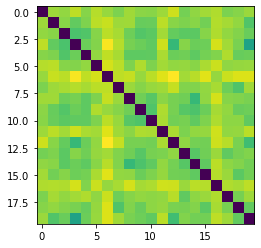

In [99]:
plt.imshow(D)

In [100]:
pca = PCA(n_components=2)

In [101]:
z = pca.fit_transform(X)

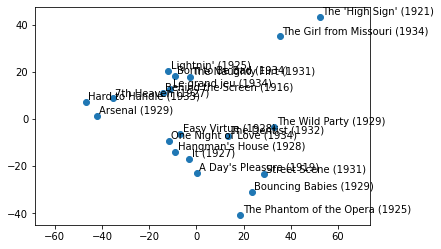

In [102]:
plt.scatter(z[:, 0], z[:, 1])
ax = plt.gca()
plt.axis('equal')
for i in range(len(z)):
    ax.text(z[i, 0]+1, z[i, 1]+1, names[i])

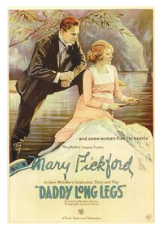

In [208]:
def show_poster(ID):
    filename = f"SampleMoviePosters/SampleMoviePosters/{ID}.jpg"
    im = Image.open(filename)
    plt.imshow(im)
    plt.axis('off')
show_poster(10040)

In [92]:
M

['SampleMoviePosters/SampleMoviePosters/15136.jpg',
 'SampleMoviePosters/SampleMoviePosters/12881.jpg',
 'SampleMoviePosters/SampleMoviePosters/23241.jpg',
 'SampleMoviePosters/SampleMoviePosters/22639.jpg',
 'SampleMoviePosters/SampleMoviePosters/19644.jpg',
 'SampleMoviePosters/SampleMoviePosters/14406.jpg',
 'SampleMoviePosters/SampleMoviePosters/13427.jpg',
 'SampleMoviePosters/SampleMoviePosters/18566.jpg',
 'SampleMoviePosters/SampleMoviePosters/13802.jpg',
 'SampleMoviePosters/SampleMoviePosters/20210.jpg',
 'SampleMoviePosters/SampleMoviePosters/21668.jpg',
 'SampleMoviePosters/SampleMoviePosters/24710.jpg',
 'SampleMoviePosters/SampleMoviePosters/23731.jpg',
 'SampleMoviePosters/SampleMoviePosters/23902.jpg',
 'SampleMoviePosters/SampleMoviePosters/21873.jpg',
 'SampleMoviePosters/SampleMoviePosters/16013.jpg',
 'SampleMoviePosters/SampleMoviePosters/25397.jpg',
 'SampleMoviePosters/SampleMoviePosters/18770.jpg',
 'SampleMoviePosters/SampleMoviePosters/20589.jpg',
 'SampleMovi

In [93]:
M[0]

'SampleMoviePosters/SampleMoviePosters/15136.jpg'

In [94]:
M[8], M[9], M[-1]

('SampleMoviePosters/SampleMoviePosters/13802.jpg',
 'SampleMoviePosters/SampleMoviePosters/20210.jpg',
 'SampleMoviePosters/SampleMoviePosters/15532.jpg')

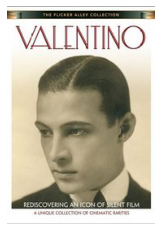

In [95]:
show_poster(13802)

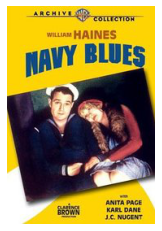

In [96]:
show_poster(20210)

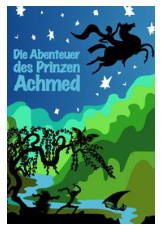

In [97]:
show_poster(15532)

In [127]:
year_pred = models.Sequential([
    layers.Dropout(0.1),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(10, activation="relu"),    
    layers.Dense(1)
])

In [128]:
year_pred.compile(loss="mse")

In [129]:
X.shape

(997, 1280)

In [130]:
years.shape

TensorShape([997])

In [144]:
years = (years - 1970.0) * 0.05

In [135]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [145]:

year_pred.fit(X, years, validation_split=0.1, epochs=500,
             callbacks=[tensorboard_callback])

Epoch 1/500
29/29 [==============================] - 1s 9ms/step - loss: 927847.3125 - val_loss: 122121.2891
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 77217.3906 - val_loss: 8300.9102
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 26158.9727 - val_loss: 2313.7168
Epoch 4/500
29/29 [==============================] - 0s 6ms/step - loss: 11427.8682 - val_loss: 800.6010
Epoch 5/500
29/29 [==============================] - 0s 6ms/step - loss: 5117.0576 - val_loss: 649.6356
Epoch 6/500
29/29 [==============================] - 0s 6ms/step - loss: 2352.7581 - val_loss: 424.2592
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 1083.9900 - val_loss: 614.0341
Epoch 8/500
29/29 [==============================] - 0s 6ms/step - loss: 711.9950 - val_loss: 187.0231
Epoch 9/500
29/29 [==============================] - 0s 6ms/step - loss: 304.3287 - val_loss: 234.7809
Epoch 10/500
29/29 [==============================] - 0s

29/29 [==============================] - 0s 5ms/step - loss: 0.9177 - val_loss: 1.4859
Epoch 83/500
29/29 [==============================] - 0s 5ms/step - loss: 1.1084 - val_loss: 0.6611
Epoch 84/500
29/29 [==============================] - 0s 5ms/step - loss: 0.7609 - val_loss: 2.0939
Epoch 85/500
29/29 [==============================] - 0s 8ms/step - loss: 0.6582 - val_loss: 1.0842
Epoch 86/500
29/29 [==============================] - 0s 6ms/step - loss: 0.7367 - val_loss: 0.7997
Epoch 87/500
29/29 [==============================] - 0s 6ms/step - loss: 1.0114 - val_loss: 1.1323
Epoch 88/500
29/29 [==============================] - 0s 5ms/step - loss: 0.5962 - val_loss: 0.5625
Epoch 89/500
29/29 [==============================] - 0s 5ms/step - loss: 0.6519 - val_loss: 1.2230
Epoch 90/500
29/29 [==============================] - 0s 5ms/step - loss: 0.6646 - val_loss: 1.9397
Epoch 91/500
29/29 [==============================] - 0s 5ms/step - loss: 0.7151 - val_loss: 0.6327
Epoch 92/500


29/29 [==============================] - 0s 6ms/step - loss: 0.4339 - val_loss: 0.6422
Epoch 164/500
29/29 [==============================] - 0s 9ms/step - loss: 0.5422 - val_loss: 2.1218
Epoch 165/500
29/29 [==============================] - 0s 8ms/step - loss: 0.8452 - val_loss: 0.8054
Epoch 166/500
29/29 [==============================] - 0s 6ms/step - loss: 0.6488 - val_loss: 1.3010
Epoch 167/500
29/29 [==============================] - 0s 8ms/step - loss: 0.4222 - val_loss: 2.3553
Epoch 168/500
29/29 [==============================] - 0s 9ms/step - loss: 0.5836 - val_loss: 2.0257
Epoch 169/500
29/29 [==============================] - 0s 12ms/step - loss: 0.5833 - val_loss: 1.5017
Epoch 170/500
29/29 [==============================] - 0s 8ms/step - loss: 0.5824 - val_loss: 1.5904
Epoch 171/500
29/29 [==============================] - 0s 7ms/step - loss: 0.3835 - val_loss: 3.4097
Epoch 172/500
29/29 [==============================] - 0s 7ms/step - loss: 0.3806 - val_loss: 0.5330
Epo

29/29 [==============================] - 0s 5ms/step - loss: 0.3806 - val_loss: 0.6795
Epoch 245/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4451 - val_loss: 0.7294
Epoch 246/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2976 - val_loss: 2.4765
Epoch 247/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4379 - val_loss: 0.3297
Epoch 248/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4493 - val_loss: 0.5676
Epoch 249/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4041 - val_loss: 1.2725
Epoch 250/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2917 - val_loss: 2.6435
Epoch 251/500
29/29 [==============================] - 0s 5ms/step - loss: 0.3890 - val_loss: 1.1309
Epoch 252/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2429 - val_loss: 1.3473
Epoch 253/500
29/29 [==============================] - 0s 5ms/step - loss: 0.3421 - val_loss: 0.4628
Epoc

29/29 [==============================] - 0s 5ms/step - loss: 0.1816 - val_loss: 0.8399
Epoch 326/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2008 - val_loss: 2.6498
Epoch 327/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2146 - val_loss: 0.9068
Epoch 328/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2066 - val_loss: 0.5961
Epoch 329/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2132 - val_loss: 1.1051
Epoch 330/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2211 - val_loss: 0.3063
Epoch 331/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1879 - val_loss: 0.3255
Epoch 332/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1591 - val_loss: 0.2582
Epoch 333/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2065 - val_loss: 0.2648
Epoch 334/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2046 - val_loss: 0.2773
Epoc

29/29 [==============================] - 0s 5ms/step - loss: 0.1498 - val_loss: 0.2286
Epoch 407/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1525 - val_loss: 0.6170
Epoch 408/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1592 - val_loss: 1.7116
Epoch 409/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1390 - val_loss: 0.2662
Epoch 410/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1305 - val_loss: 0.9367
Epoch 411/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1604 - val_loss: 1.3662
Epoch 412/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1414 - val_loss: 0.6678
Epoch 413/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1393 - val_loss: 0.8682
Epoch 414/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1471 - val_loss: 0.3104
Epoch 415/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1366 - val_loss: 0.2531
Epoc

29/29 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0833
Epoch 488/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.0929
Epoch 489/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0562 - val_loss: 0.1733
Epoch 490/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0568 - val_loss: 0.0863
Epoch 491/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0531 - val_loss: 0.1801
Epoch 492/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.1227
Epoch 493/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.2058
Epoch 494/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: 0.0775
Epoch 495/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0587 - val_loss: 0.1397
Epoch 496/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0499 - val_loss: 0.1631
Epoc

In [133]:
%load_ext tensorboard

In [146]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 62648), started 0:07:01 ago. (Use '!kill 62648' to kill it.)

In [147]:
year_pred(X[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.955203 ],
       [-1.9777265],
       [-2.1520076],
       [-1.9501352],
       [-1.9304647]], dtype=float32)>

In [148]:
years[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-2.05     , -2.25     , -2.7      , -1.85     , -1.8000001],
      dtype=float32)>

In [149]:
def rescale(y):
    return y * 20 + 1970


In [154]:
rescale(year_pred(X[900:910]))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1930.9117],
       [1931.0968],
       [1927.4674],
       [1930.712 ],
       [1930.6849],
       [1931.1313],
       [1926.7935],
       [1930.9298],
       [1930.8237],
       [1930.8765]], dtype=float32)>

In [155]:
rescale(years[900:910])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1924., 1929., 1933., 1931., 1931., 1919., 1917., 1923., 1932.,
       1934.], dtype=float32)>

In [157]:
rescale(years)

<tf.Tensor: shape=(997,), dtype=float32, numpy=
array([1929., 1925., 1916., 1933., 1934., 1927., 1921., 1931., 1928.,
       1931., 1934., 1925., 1929., 1932., 1928., 1934., 1934., 1929.,
       1919., 1927., 1928., 1929., 1931., 1928., 1933., 1915., 1926.,
       1916., 1931., 1934., 1928., 1934., 1924., 1934., 1921., 1933.,
       1932., 1928., 1924., 1934., 1918., 1913., 1932., 1932., 1929.,
       1923., 1932., 1933., 1925., 1927., 1930., 1932., 1931., 1931.,
       1932., 1926., 1933., 1929., 1927., 1928., 1931., 1933., 1928.,
       1929., 1921., 1928., 1920., 1928., 1931., 1933., 1928., 1930.,
       1933., 1922., 1913., 1924., 1929., 1933., 1922., 1931., 1934.,
       1916., 1919., 1929., 1919., 1932., 1927., 1920., 1930., 1925.,
       1934., 1934., 1933., 1933., 1918., 1933., 1928., 1930., 1927.,
       1930., 1927., 1916., 1915., 1929., 1923., 1927., 1916., 1932.,
       1930., 1931., 1928., 1920., 1926., 1929., 1931., 1922., 1920.,
       1930., 1926., 1925., 1934., 1931., 

In [164]:
L2 = []
for dirname, _, filenames in os.walk('poster_downloads'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            L2.append(os.path.join(dirname, filename))

In [174]:
for filename in L2:
    bname = os.path.basename(filename)[:-4]
    score, ID = bname.split("_")
    ID = int(ID)
    print(ID)
    print(df[df["imdbId"] == ID])

300471
      imdbId                           Imdb Link                    Title  \
6058  300471  http://www.imdb.com/title/tt300471  Shanghai Knights (2003)   

      IMDB Score                    Genre  \
6058         6.2  Action|Adventure|Comedy   

                                                 Poster  
6058  https://images-na.ssl-images-amazon.com/images...  
91187
      imdbId                          Imdb Link                    Title  \
2392   91187  http://www.imdb.com/title/tt91187  Heartbreak Ridge (1986)   

      IMDB Score                Genre  \
2392         6.8  Action|Comedy|Drama   

                                                 Poster  
2392  https://images-na.ssl-images-amazon.com/images...  
330602
      imdbId                           Imdb Link                  Title  \
6660  330602  http://www.imdb.com/title/tt330602  Mambo Italiano (2003)   

      IMDB Score                 Genre  \
6660         6.7  Comedy|Drama|Romance   

                              

5249  https://images-na.ssl-images-amazon.com/images...  
63642
      imdbId                          Imdb Link         Title  IMDB Score  \
7795   63642  http://www.imdb.com/title/tt63642  Star! (1968)         6.6   

                       Genre  \
7795  Biography|Comedy|Drama   

                                                 Poster  
7795  https://images-na.ssl-images-amazon.com/images...  
227445
      imdbId                           Imdb Link             Title  \
4354  227445  http://www.imdb.com/title/tt227445  The Score (2001)   

      IMDB Score                 Genre  \
4354         6.8  Crime|Drama|Thriller   

                                                 Poster  
4354  https://images-na.ssl-images-amazon.com/images...  
94602
      imdbId                          Imdb Link                 Title  \
4372   94602  http://www.imdb.com/title/tt94602  Above the Law (1988)   

      IMDB Score               Genre  \
4372         5.9  Action|Crime|Drama   

                 

6003  https://images-na.ssl-images-amazon.com/images...  
119832
      imdbId                           Imdb Link                   Title  \
1611  119832  http://www.imdb.com/title/tt119832  One Night Stand (1997)   

      IMDB Score          Genre  \
1611         5.9  Drama|Romance   

                                                 Poster  
1611  https://images-na.ssl-images-amazon.com/images...  
361620
      imdbId                           Imdb Link                  Title  \
8186  361620  http://www.imdb.com/title/tt361620  First Daughter (2004)   

      IMDB Score                 Genre  \
8186         5.0  Comedy|Drama|Romance   

                                                 Poster  
8186  https://images-na.ssl-images-amazon.com/images...  
57579
      imdbId                          Imdb Link  \
8078   57579  http://www.imdb.com/title/tt57579   

                                    Title  IMDB Score         Genre  \
8078  The Three Lives of Thomasina (1963)         7.3  D

2105  Drama|Music  https://images-na.ssl-images-amazon.com/images...  
89167
      imdbId                          Imdb Link                       Title  \
5182   89167  http://www.imdb.com/title/tt89167  Fraternity Vacation (1985)   

      IMDB Score   Genre                                             Poster  
5182         4.9  Comedy  https://images-na.ssl-images-amazon.com/images...  
142342
      imdbId                           Imdb Link             Title  \
2609  142342  http://www.imdb.com/title/tt142342  Big Daddy (1999)   

      IMDB Score                Genre  \
2609         6.4  Comedy|Drama|Family   

                                                 Poster  
2609  https://images-na.ssl-images-amazon.com/images...  
66995
      imdbId                          Imdb Link                        Title  \
3891   66995  http://www.imdb.com/title/tt66995  Diamonds Are Forever (1971)   

      IMDB Score                      Genre  \
3891         6.7  Action|Adventure|Thriller   


1986         7.6  Drama  https://images-na.ssl-images-amazon.com/images...  
113443
     imdbId                           Imdb Link                 Title  \
675  113443  http://www.imdb.com/title/tt113443  It's My Party (1996)   

     IMDB Score  Genre                                             Poster  
675         7.1  Drama  https://images-na.ssl-images-amazon.com/images...  
110649
     imdbId                           Imdb Link               Title  \
499  110649  http://www.imdb.com/title/tt110649  The New Age (1994)   

     IMDB Score         Genre  \
499         5.8  Comedy|Drama   

                                                Poster  
499  https://images-na.ssl-images-amazon.com/images...  
107985
      imdbId                           Imdb Link                      Title  \
5007  107985  http://www.imdb.com/title/tt107985  Rookie of the Year (1993)   

      IMDB Score                  Genre  \
5007         5.9  Comedy|Family|Fantasy   

                                 

4069  https://images-na.ssl-images-amazon.com/images...  
87337
      imdbId                          Imdb Link  \
7791   87337  http://www.imdb.com/title/tt87337   

                                       Title  IMDB Score        Genre  \
7791  Give My Regards to Broad Street (1984)         5.2  Drama|Music   

                                                 Poster  
7791  https://images-na.ssl-images-amazon.com/images...  
117608
     imdbId                           Imdb Link              Title  \
630  117608  http://www.imdb.com/title/tt117608  Sgt. Bilko (1996)   

     IMDB Score   Genre                                             Poster  
630         5.7  Comedy  https://images-na.ssl-images-amazon.com/images...  
18742
      imdbId                          Imdb Link                 Title  \
8361   18742  http://www.imdb.com/title/tt18742  The Cameraman (1928)   

      IMDB Score                  Genre  \
8361         8.3  Comedy|Romance|Family   

                            

8846  Drama|Mystery|Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
105631
      imdbId                           Imdb Link                 Title  \
5345  105631  http://www.imdb.com/title/tt105631  Traces of Red (1992)   

      IMDB Score                Genre  \
5345         5.2  Crime|Drama|Mystery   

                                                 Poster  
5345  https://images-na.ssl-images-amazon.com/images...  
233418
      imdbId                           Imdb Link          Title  IMDB Score  \
6446  233418  http://www.imdb.com/title/tt233418  Cavale (2002)         7.0   

                     Genre                                             Poster  
6446  Thriller|Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
115964
      imdbId                           Imdb Link         Title  IMDB Score  \
1443  115964  http://www.imdb.com/title/tt115964  Crash (1996)         6.4   

      Genre                                             Poster  
1443  Dram

5777  https://images-na.ssl-images-amazon.com/images...  
272338
      imdbId                           Imdb Link                    Title  \
5575  272338  http://www.imdb.com/title/tt272338  Punch-Drunk Love (2002)   

      IMDB Score                 Genre  \
5575         7.3  Comedy|Drama|Romance   

                                                 Poster  
5575  https://images-na.ssl-images-amazon.com/images...  
120576
      imdbId                           Imdb Link                 Title  \
2085  120576  http://www.imdb.com/title/tt120576  Dance with Me (1998)   

      IMDB Score                Genre  \
2085         5.8  Drama|Romance|Music   

                                                 Poster  
2085  https://images-na.ssl-images-amazon.com/images...  
67334
      imdbId                          Imdb Link           Title  IMDB Score  \
6292   67334  http://www.imdb.com/title/tt67334  Le Mans (1971)         6.7   

                       Genre  \
6292  Action|Adventure|Dram

4122  https://images-na.ssl-images-amazon.com/images...  
118750
      imdbId                           Imdb Link              Title  \
1431  118750  http://www.imdb.com/title/tt118750  Booty Call (1997)   

      IMDB Score           Genre  \
1431         5.3  Comedy|Romance   

                                                 Poster  
1431  https://images-na.ssl-images-amazon.com/images...  
37800
      imdbId                          Imdb Link  \
4101   37800  http://www.imdb.com/title/tt37800   

                                 Title  IMDB Score          Genre  \
4101  'I Know Where I'm Going!' (1945)         7.7  Drama|Romance   

                                                 Poster  
4101  https://images-na.ssl-images-amazon.com/images...  
33149
      imdbId                          Imdb Link                       Title  \
7107   33149  http://www.imdb.com/title/tt33149  They Drive by Night (1940)   

      IMDB Score                  Genre  \
7107         7.3  Crime|Drama|F

      imdbId                          Imdb Link  \
8601   56300  http://www.imdb.com/title/tt56300   

                                      Title  IMDB Score  \
8601  Occurrence at Owl Creek Bridge (1962)         8.2   

                      Genre                                             Poster  
8601  Short|Adventure|Drama  https://images-na.ssl-images-amazon.com/images...  
216772
      imdbId                           Imdb Link              Title  \
3799  216772  http://www.imdb.com/title/tt216772  Turn It Up (2000)   

      IMDB Score               Genre  \
3799         4.4  Crime|Drama|Action   

                                                 Poster  
3799  https://images-na.ssl-images-amazon.com/images...  
91278
      imdbId                          Imdb Link              Title  \
2730   91278  http://www.imdb.com/title/tt91278  Iron Eagle (1986)   

      IMDB Score                Genre  \
2730         5.3  Action|Thriller|War   

                                       

6715  Biography|Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
349825
      imdbId                           Imdb Link           Title  IMDB Score  \
7151  349825  http://www.imdb.com/title/tt349825  Miracle (2004)         7.5   

                        Genre  \
7151  Biography|Drama|History   

                                                 Poster  
7151  https://images-na.ssl-images-amazon.com/images...  
116683
     imdbId                           Imdb Link  \
653  116683  http://www.imdb.com/title/tt116683   

                                Title  IMDB Score                       Genre  \
653  James and the Giant Peach (1996)         6.7  Animation|Adventure|Family   

                                                Poster  
653  https://images-na.ssl-images-amazon.com/images...  
46754
      imdbId                          Imdb Link                         Title  \
4326   46754  http://www.imdb.com/title/tt46754  The Barefoot Contessa (1954)   

      IMDB S

      imdbId                          Imdb Link                Title  \
8926   90270  http://www.imdb.com/title/tt90270  Vision Quest (1985)   

      IMDB Score                Genre  \
8926         6.5  Drama|Romance|Sport   

                                                 Poster  
8926  https://images-na.ssl-images-amazon.com/images...  
81499
      imdbId                          Imdb Link                 Title  \
5147   81499  http://www.imdb.com/title/tt81499  Shi di chu ma (1980)   

      IMDB Score                    Genre  \
5147         7.3  Action|Adventure|Comedy   

                                                 Poster  
5147  https://images-na.ssl-images-amazon.com/images...  
36376
      imdbId                          Imdb Link                  Title  \
2568   36376  http://www.imdb.com/title/tt36376  Son of Dracula (1943)   

      IMDB Score           Genre  \
2568         6.2  Fantasy|Horror   

                                                 Poster  
2568  http

954  https://images-na.ssl-images-amazon.com/images...  
339034
      imdbId                           Imdb Link                        Title  \
6374  339034  http://www.imdb.com/title/tt339034  From Justin to Kelly (2003)   

      IMDB Score                   Genre  \
6374         2.1  Comedy|Musical|Romance   

                                                 Poster  
6374  https://images-na.ssl-images-amazon.com/images...  
82418
      imdbId                          Imdb Link  \
1892   82418  http://www.imdb.com/title/tt82418   

                              Title  IMDB Score                    Genre  \
1892  Friday the 13th Part 2 (1981)         6.1  Horror|Mystery|Thriller   

                                                 Poster  
1892  https://images-na.ssl-images-amazon.com/images...  
123987
      imdbId                           Imdb Link            Title  IMDB Score  \
1836  123987  http://www.imdb.com/title/tt123987  Madeline (1998)         5.9   

              Genre 

     imdbId                           Imdb Link           Title  IMDB Score  \
738  103926  http://www.imdb.com/title/tt103926  Careful (1992)         7.2   

                    Genre                                             Poster  
738  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
81059
      imdbId                          Imdb Link                      Title  \
5100   81059  http://www.imdb.com/title/tt81059  Lion of the Desert (1980)   

      IMDB Score                    Genre  \
5100         8.4  Biography|Drama|History   

                                                 Poster  
5100  https://images-na.ssl-images-amazon.com/images...  
119815
      imdbId                           Imdb Link  \
1693  119815  http://www.imdb.com/title/tt119815   

                              Title  IMDB Score                 Genre  \
1693  Four Days in September (1997)         7.4  Action|Drama|History   

                                                 Poste

92  https://images-na.ssl-images-amazon.com/images...  
116953
      imdbId                           Imdb Link                Title  \
1284  116953  http://www.imdb.com/title/tt116953  Mad Dog Time (1996)   

      IMDB Score               Genre  \
1284         5.5  Comedy|Crime|Drama   

                                                 Poster  
1284  https://images-na.ssl-images-amazon.com/images...  
339419
      imdbId                           Imdb Link                 Title  \
7329  339419  http://www.imdb.com/title/tt339419  The Mudge Boy (2003)   

      IMDB Score                Genre  \
7329         7.2  Crime|Drama|Romance   

                                                 Poster  
7329  https://images-na.ssl-images-amazon.com/images...  
117320
      imdbId                           Imdb Link                       Title  \
1100  117320  http://www.imdb.com/title/tt117320  A Perfect Candidate (1996)   

      IMDB Score        Genre  \
1100         7.3  Documentary   

   

3962  Comedy|Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
76704
      imdbId                          Imdb Link               Title  \
5497   76704  http://www.imdb.com/title/tt76704  Shock Waves (1977)   

      IMDB Score                  Genre  \
5497         5.7  Horror|Mystery|Sci-Fi   

                                                 Poster  
5497  https://images-na.ssl-images-amazon.com/images...  
18328
      imdbId                          Imdb Link            Title  IMDB Score  \
2143   18328  http://www.imdb.com/title/tt18328  The Ring (1927)         6.2   

                    Genre                                             Poster  
2143  Drama|Romance|Sport  https://images-na.ssl-images-amazon.com/images...  
84549
      imdbId                          Imdb Link             Title  IMDB Score  \
6020   84549  http://www.imdb.com/title/tt84549  Przypadek (1987)         8.0   

      Genre                                             Poster  
6020  Drama

5276  https://images-na.ssl-images-amazon.com/images...  
103285
      imdbId                           Imdb Link                 Title  \
6612  103285  http://www.imdb.com/title/tt103285  Wong Fei Hung (1991)   

      IMDB Score                       Genre  \
6612         7.4  Action|Adventure|Biography   

                                                 Poster  
6612  https://images-na.ssl-images-amazon.com/images...  
76489
      imdbId                          Imdb Link            Title  IMDB Score  \
5118   76489  http://www.imdb.com/title/tt76489  Oh, God! (1977)         6.6   

               Genre                                             Poster  
5118  Comedy|Fantasy  https://images-na.ssl-images-amazon.com/images...  
71402
      imdbId                          Imdb Link              Title  \
3342   71402  http://www.imdb.com/title/tt71402  Death Wish (1974)   

      IMDB Score               Genre  \
3342         7.0  Action|Crime|Drama   

                              

3526  Comedy|Romance  https://images-na.ssl-images-amazon.com/images...  
181739
      imdbId                           Imdb Link                 Title  \
4625  181739  http://www.imdb.com/title/tt181739  Osmosis Jones (2001)   

      IMDB Score                       Genre  \
4625         6.2  Animation|Action|Adventure   

                                                 Poster  
4625  https://images-na.ssl-images-amazon.com/images...  
57128
      imdbId                          Imdb Link                      Title  \
7548   57128  http://www.imdb.com/title/tt57128  The Haunted Palace (1963)   

      IMDB Score   Genre                                             Poster  
7548         6.8  Horror  https://images-na.ssl-images-amazon.com/images...  
117883
      imdbId                           Imdb Link         Title  IMDB Score  \
5474  117883  http://www.imdb.com/title/tt117883  Tesis (1996)         7.5   

                        Genre  \
5474  Horror|Mystery|Thriller   

       

7038  https://images-na.ssl-images-amazon.com/images...  
46911
      imdbId                          Imdb Link              Title  \
7005   46911  http://www.imdb.com/title/tt46911  Diabolique (1955)   

      IMDB Score               Genre  \
7005         8.1  Crime|Drama|Horror   

                                                 Poster  
7005  https://images-na.ssl-images-amazon.com/images...  
114134
      imdbId                           Imdb Link                   Title  \
1504  114134  http://www.imdb.com/title/tt114134  The Pillow Book (1996)   

      IMDB Score  Genre                                             Poster  
1504         6.7  Drama  https://images-na.ssl-images-amazon.com/images...  
28010
     imdbId                          Imdb Link                  Title  \
930   28010  http://www.imdb.com/title/tt28010  My Man Godfrey (1936)   

     IMDB Score                 Genre  \
930         8.1  Comedy|Drama|Romance   

                                                

5585  https://images-na.ssl-images-amazon.com/images...  
50629
      imdbId                          Imdb Link                      Title  \
5869   50629  http://www.imdb.com/title/tt50629  Legend of the Lost (1957)   

      IMDB Score            Genre  \
5869         6.1  Adventure|Drama   

                                                 Poster  
5869  https://images-na.ssl-images-amazon.com/images...  
268978
      imdbId                           Imdb Link                    Title  \
4900  268978  http://www.imdb.com/title/tt268978  A Beautiful Mind (2001)   

      IMDB Score            Genre  \
4900         8.2  Biography|Drama   

                                                 Poster  
4900  https://images-na.ssl-images-amazon.com/images...  
118661
      imdbId                           Imdb Link                Title  \
2070  118661  http://www.imdb.com/title/tt118661  The Avengers (1998)   

      IMDB Score                    Genre  \
2070         3.7  Action|Adventure|S

8383         7.7  Drama  https://images-na.ssl-images-amazon.com/images...  
110097
     imdbId                           Imdb Link                    Title  \
468  110097  http://www.imdb.com/title/tt110097  I'll Do Anything (1994)   

     IMDB Score         Genre  \
468         5.6  Comedy|Drama   

                                                Poster  
468  https://images-na.ssl-images-amazon.com/images...  
162662
      imdbId                           Imdb Link                        Title  \
8332  162662  http://www.imdb.com/title/tt162662  A Slipping-Down Life (1999)   

      IMDB Score                Genre  \
8332         6.2  Drama|Music|Romance   

                                                 Poster  
8332  https://images-na.ssl-images-amazon.com/images...  
113125
     imdbId                           Imdb Link  \
134  113125  http://www.imdb.com/title/tt113125   

                                       Title  IMDB Score  \
134  From the Journals of Jean Seberg (1995

      imdbId                           Imdb Link                  Title  \
1723  140282  http://www.imdb.com/title/tt140282  In God's Hands (1998)   

      IMDB Score               Genre  \
1723         5.5  Action|Drama|Sport   

                                                 Poster  
1723  https://images-na.ssl-images-amazon.com/images...  
80492
      imdbId                          Imdb Link                        Title  \
4736   80492  http://www.imdb.com/title/tt80492  Can't Stop the Music (1980)   

      IMDB Score                     Genre  \
4736         4.5  Biography|Comedy|Musical   

                                                 Poster  
4736  https://images-na.ssl-images-amazon.com/images...  
96978
      imdbId                          Imdb Link                Title  \
3080   96978  http://www.imdb.com/title/tt96978  Brenda Starr (1989)   

      IMDB Score                     Genre  \
3080         4.6  Adventure|Comedy|Romance   

                                

3175  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
109686
     imdbId                           Imdb Link                 Title  \
228  109686  http://www.imdb.com/title/tt109686  Dumb & Dumber (1994)   

     IMDB Score   Genre                                             Poster  
228         7.3  Comedy  https://images-na.ssl-images-amazon.com/images...  
49408
      imdbId                          Imdb Link                  Title  \
2481   49408  http://www.imdb.com/title/tt49408  The King and I (1956)   

      IMDB Score                    Genre  \
2481         7.5  Biography|Drama|Musical   

                                                 Poster  
2481  https://images-na.ssl-images-amazon.com/images...  
86837
      imdbId                          Imdb Link        Title  IMDB Score  \
2227   86837  http://www.imdb.com/title/tt86837  2010 (1984)         6.8   

                         Genre  \
2227  Adventure|Mystery|Sci-Fi   

                      

      imdbId                          Imdb Link         Title  IMDB Score  \
4376   94675  http://www.imdb.com/title/tt94675  Ariel (1988)         7.6   

                     Genre                                             Poster  
4376  Comedy|Crime|Romance  https://images-na.ssl-images-amazon.com/images...  
168987
      imdbId                           Imdb Link  \
2689  168987  http://www.imdb.com/title/tt168987   

                             Title  IMDB Score                 Genre  \
2689  Better Than Chocolate (1999)         6.2  Comedy|Drama|Romance   

                                                 Poster  
2689  https://images-na.ssl-images-amazon.com/images...  
104922
      imdbId                           Imdb Link            Title  IMDB Score  \
4923  104922  http://www.imdb.com/title/tt104922  Motorama (1991)         6.4   

                       Genre  \
4923  Adventure|Comedy|Crime   

                                                 Poster  
4923  https://image

28629
      imdbId                          Imdb Link             Title  IMDB Score  \
3296   28629  http://www.imdb.com/title/tt28629  Big Fella (1937)         6.2   

              Genre                                             Poster  
3296  Drama|Musical  https://images-na.ssl-images-amazon.com/images...  
118756
      imdbId                           Imdb Link            Title  IMDB Score  \
5573  118756  http://www.imdb.com/title/tt118756  Le bossu (1997)         7.0   

                Genre                                             Poster  
5573  Drama|Adventure  https://images-na.ssl-images-amazon.com/images...  
69191
      imdbId                          Imdb Link        Title  IMDB Score  \
4189   69191  http://www.imdb.com/title/tt69191  Roma (1972)         7.4   

             Genre                                             Poster  
4189  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
102303
      imdbId                           Imdb Link       

      imdbId                           Imdb Link                 Title  \
6299  100827  http://www.imdb.com/title/tt100827  Two Evil Eyes (1990)   

      IMDB Score   Genre                                             Poster  
6299         6.1  Horror  https://images-na.ssl-images-amazon.com/images...  
374546
      imdbId                           Imdb Link  \
7619  374546  http://www.imdb.com/title/tt374546   

                                                  Title  IMDB Score  \
7619  Spring, Summer, Fall, Winter... and Spring (2003)         8.1   

              Genre                                             Poster  
7619  Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
138946
      imdbId                           Imdb Link             Title  \
2684  138946  http://www.imdb.com/title/tt138946  The Yards (2000)   

      IMDB Score                Genre  \
2684         6.4  Crime|Drama|Romance   

                                                 Poster  
2684 

888  https://images-na.ssl-images-amazon.com/images...  
102492
      imdbId                           Imdb Link           Title  IMDB Score  \
5872  102492  http://www.imdb.com/title/tt102492  My Girl (1991)         6.8   

                    Genre                                             Poster  
5872  Comedy|Drama|Family  https://images-na.ssl-images-amazon.com/images...  
291538
      imdbId                           Imdb Link                        Title  \
6435  291538  http://www.imdb.com/title/tt291538  Une femme de mí©nage (2002)   

      IMDB Score                 Genre  \
6435         6.3  Comedy|Drama|Romance   

                                                 Poster  
6435  https://images-na.ssl-images-amazon.com/images...  
179196
      imdbId                           Imdb Link  \
2994  179196  http://www.imdb.com/title/tt179196   

                             Title  IMDB Score                     Genre  \
2994  Goodbye, 20th Century (1998)         7.0  Adventure|

      imdbId                           Imdb Link              Title  \
2791  111419  http://www.imdb.com/title/tt111419  Thumbelina (1994)   

      IMDB Score                     Genre  \
2791         6.3  Animation|Family|Fantasy   

                                                 Poster  
2791  https://images-na.ssl-images-amazon.com/images...  
95288
      imdbId                          Imdb Link                    Title  \
4416   95288  http://www.imdb.com/title/tt95288  Heartbreak Hotel (1988)   

      IMDB Score                   Genre  \
4416         5.7  Comedy|Musical|Romance   

                                                 Poster  
4416  https://images-na.ssl-images-amazon.com/images...  
171685
      imdbId                           Imdb Link              Title  \
5507  171685  http://www.imdb.com/title/tt171685  Ratcatcher (1999)   

      IMDB Score  Genre                                             Poster  
5507         7.5  Drama  https://images-na.ssl-images-ama

6310  https://images-na.ssl-images-amazon.com/images...  
56600
      imdbId                          Imdb Link                   Title  \
3958   56600  http://www.imdb.com/title/tt56600  Body in the Web (1960)   

      IMDB Score   Genre                                             Poster  
3958         2.4  Horror  https://images-na.ssl-images-amazon.com/images...  
278823
      imdbId                           Imdb Link                    Title  \
5252  278823  http://www.imdb.com/title/tt278823  Hollywood Ending (2002)   

      IMDB Score           Genre  \
5252         6.6  Comedy|Romance   

                                                 Poster  
5252  https://images-na.ssl-images-amazon.com/images...  
65755
      imdbId                          Imdb Link                        Title  \
8700   65755  http://www.imdb.com/title/tt65755  Gamera vs. Monster X (1970)   

      IMDB Score                    Genre  \
8700         5.7  Action|Adventure|Family   

                    

2072  https://images-na.ssl-images-amazon.com/images...  
97336
      imdbId                          Imdb Link  \
4501   97336  http://www.imdb.com/title/tt97336   

                              Title  IMDB Score                    Genre  \
4501  Fat Man and Little Boy (1989)         6.5  Biography|Drama|History   

                                                 Poster  
4501  https://images-na.ssl-images-amazon.com/images...  
54642
      imdbId                          Imdb Link  \
7677   54642  http://www.imdb.com/title/tt54642   

                                    Title  IMDB Score             Genre  \
7677  Atlantis: The Lost Continent (1961)         5.5  Adventure|Sci-Fi   

                                                 Poster  
7677  https://images-na.ssl-images-amazon.com/images...  
196229
      imdbId                           Imdb Link             Title  \
4721  196229  http://www.imdb.com/title/tt196229  Zoolander (2001)   

      IMDB Score   Genre                

4558  https://images-na.ssl-images-amazon.com/images...  
375063
      imdbId                           Imdb Link            Title  IMDB Score  \
8266  375063  http://www.imdb.com/title/tt375063  Sideways (2004)         7.5   

                     Genre                                             Poster  
8266  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
320244
      imdbId                           Imdb Link                 Title  \
6596  320244  http://www.imdb.com/title/tt320244  Party Monster (2003)   

      IMDB Score                  Genre  \
6596         6.3  Biography|Crime|Drama   

                                                 Poster  
6596  https://images-na.ssl-images-amazon.com/images...  
92850
      imdbId                          Imdb Link                    Title  \
2669   92850  http://www.imdb.com/title/tt92850  Deadtime Stories (1986)   

      IMDB Score          Genre  \
2669         4.6  Comedy|Horror   

                       

      imdbId                          Imdb Link                 Title  \
6149   66579  http://www.imdb.com/title/tt66579  Women in Love (1969)   

      IMDB Score          Genre  \
6149         7.6  Drama|Romance   

                                                 Poster  
6149  https://images-na.ssl-images-amazon.com/images...  
80738
      imdbId                          Imdb Link                        Title  \
4845   80738  http://www.imdb.com/title/tt80738  The First Deadly Sin (1980)   

      IMDB Score     Genre                                             Poster  
4845         5.9  Thriller  https://images-na.ssl-images-amazon.com/images...  
90685
      imdbId                          Imdb Link                  Title  \
2332   90685  http://www.imdb.com/title/tt90685  Back to School (1986)   

      IMDB Score                 Genre  \
2332         6.6  Comedy|Romance|Sport   

                                                 Poster  
2332  https://images-na.ssl-images-amazon

416  https://images-na.ssl-images-amazon.com/images...  
119094
      imdbId                           Imdb Link            Title  IMDB Score  \
1522  119094  http://www.imdb.com/title/tt119094  Face/Off (1997)         7.3   

                    Genre                                             Poster  
1522  Action|Crime|Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
108592
      imdbId                           Imdb Link  \
6614  108592  http://www.imdb.com/title/tt108592   

                                     Title  IMDB Score  \
6614  Once Upon a Time in China III (1993)         6.8   

                           Genre  \
6614  Action|Adventure|Biography   

                                                 Poster  
6614  https://images-na.ssl-images-amazon.com/images...  
98194
      imdbId                          Imdb Link  \
4559   98194  http://www.imdb.com/title/tt98194   

                                    Title  IMDB Score  \
4559  The Return of the Muskete

1418  https://images-na.ssl-images-amazon.com/images...  
100604
      imdbId                           Imdb Link              Title  \
7735  100604  http://www.imdb.com/title/tt100604  Short Time (1990)   

      IMDB Score               Genre  \
7735         6.4  Comedy|Crime|Drama   

                                                 Poster  
7735  https://images-na.ssl-images-amazon.com/images...  
111804
     imdbId                           Imdb Link  \
407  111804  http://www.imdb.com/title/tt111804   

                                    Title  IMDB Score               Genre  \
407  Martin Lawrence: You So Crazy (1994)         6.6  Documentary|Comedy   

                                                Poster  
407  https://images-na.ssl-images-amazon.com/images...  
277895
      imdbId                           Imdb Link          Title  IMDB Score  \
7326  277895  http://www.imdb.com/title/tt277895  Mickey (2004)         6.8   

            Genre                                 

3805  https://images-na.ssl-images-amazon.com/images...  
133117
      imdbId                           Imdb Link                    Title  \
2873  133117  http://www.imdb.com/title/tt133117  Naturally Native (1998)   

      IMDB Score  Genre                                             Poster  
2873         6.5  Drama  https://images-na.ssl-images-amazon.com/images...  
234570
      imdbId                           Imdb Link       Title  IMDB Score  \
4175  234570  http://www.imdb.com/title/tt234570  Rat (2000)         6.0   

                    Genre                                             Poster  
4175  Comedy|Drama|Family  https://images-na.ssl-images-amazon.com/images...  
273253
      imdbId                           Imdb Link                Title  \
4678  273253  http://www.imdb.com/title/tt273253  Haiku Tunnel (2001)   

      IMDB Score   Genre                                             Poster  
4678         6.1  Comedy  https://images-na.ssl-images-amazon.com/images... 

      imdbId                           Imdb Link         Title  IMDB Score  \
6082  100442  http://www.imdb.com/title/tt100442  Q & A (1990)         6.5   

                     Genre                                             Poster  
6082  Crime|Drama|Thriller  https://images-na.ssl-images-amazon.com/images...  
113730
     imdbId                           Imdb Link                   Title  \
965  113730  http://www.imdb.com/title/tt113730  Madagascar Skin (1995)   

     IMDB Score           Genre  \
965         6.4  Comedy|Romance   

                                                Poster  
965  https://images-na.ssl-images-amazon.com/images...  
229260
      imdbId                           Imdb Link  \
3880  229260  http://www.imdb.com/title/tt229260   

                                      Title  IMDB Score  \
3880  Book of Shadows: Blair Witch 2 (2000)         4.0   

                         Genre  \
3880  Adventure|Fantasy|Horror   

                                        

8694  Drama  https://images-na.ssl-images-amazon.com/images...  
246002
      imdbId                           Imdb Link                Title  \
4156  246002  http://www.imdb.com/title/tt246002  Kingdom Come (2001)   

      IMDB Score                Genre  \
4156         5.7  Comedy|Drama|Family   

                                                 Poster  
4156  https://images-na.ssl-images-amazon.com/images...  
49096
      imdbId                          Imdb Link                    Title  \
6964   49096  http://www.imdb.com/title/tt49096  The Court Jester (1955)   

      IMDB Score                    Genre  \
6964         7.9  Adventure|Comedy|Family   

                                                 Poster  
6964  https://images-na.ssl-images-amazon.com/images...  
36349
      imdbId                          Imdb Link  \
6814   36349  http://www.imdb.com/title/tt36349   

                                     Title  IMDB Score    Genre  \
6814  Sherlock Holmes in Washington (194

7697  https://images-na.ssl-images-amazon.com/images...  
100405
     imdbId                           Imdb Link                Title  \
591  100405  http://www.imdb.com/title/tt100405  Pretty Woman (1990)   

     IMDB Score           Genre  \
591         6.9  Comedy|Romance   

                                                Poster  
591  https://images-na.ssl-images-amazon.com/images...  
59037
      imdbId                          Imdb Link                      Title  \
7849   59037  http://www.imdb.com/title/tt59037  The Cincinnati Kid (1965)   

      IMDB Score  Genre                                             Poster  
7849         7.3  Drama  https://images-na.ssl-images-amazon.com/images...  
37674
      imdbId                          Imdb Link                        Title  \
2835   37674  http://www.imdb.com/title/tt37674  Children of Paradise (1945)   

      IMDB Score          Genre  \
2835         8.4  Drama|Romance   

                                                 P

3114  https://images-na.ssl-images-amazon.com/images...  
33563
      imdbId                          Imdb Link         Title  IMDB Score  \
1010   33563  http://www.imdb.com/title/tt33563  Dumbo (1941)         7.3   

                       Genre  \
1010  Animation|Drama|Family   

                                                 Poster  
1010  https://images-na.ssl-images-amazon.com/images...  
302886
      imdbId                           Imdb Link              Title  \
6090  302886  http://www.imdb.com/title/tt302886  Old School (2003)   

      IMDB Score   Genre                                             Poster  
6090         7.2  Comedy  https://images-na.ssl-images-amazon.com/images...  
303326
      imdbId                           Imdb Link           Title  IMDB Score  \
5685  303326  http://www.imdb.com/title/tt303326  Derrida (2002)         6.5   

            Genre                                             Poster  
5685  Documentary  https://images-na.ssl-images-amazon.

8803  https://images-na.ssl-images-amazon.com/images...  
335119
      imdbId                           Imdb Link  \
7040  335119  http://www.imdb.com/title/tt335119   

                                 Title  IMDB Score                    Genre  \
7040  Girl with a Pearl Earring (2003)         7.0  Biography|Drama|Romance   

                                                 Poster  
7040  https://images-na.ssl-images-amazon.com/images...  
113972
    imdbId                           Imdb Link                Title  \
88  113972  http://www.imdb.com/title/tt113972  Nick of Time (1995)   

    IMDB Score               Genre  \
88         6.3  Action|Crime|Drama   

                                               Poster  
88  https://images-na.ssl-images-amazon.com/images...  
80453
      imdbId                          Imdb Link                   Title  \
2865   80453  http://www.imdb.com/title/tt80453  The Blue Lagoon (1980)   

      IMDB Score                    Genre  \
2865         5

8840  Comedy|Drama|Musical  https://images-na.ssl-images-amazon.com/images...  
94890
      imdbId                          Imdb Link                      Title  \
2324   94890  http://www.imdb.com/title/tt94890  Cocoon: The Return (1988)   

      IMDB Score                     Genre  \
2324         5.3  Adventure|Comedy|Mystery   

                                                 Poster  
2324  https://images-na.ssl-images-amazon.com/images...  
216689
      imdbId                           Imdb Link                  Title  \
5190  216689  http://www.imdb.com/title/tt216689  Les destiní©es (2000)   

      IMDB Score          Genre  \
5190         6.8  Drama|Romance   

                                                 Poster  
5190  https://images-na.ssl-images-amazon.com/images...  
109417
      imdbId                           Imdb Link              Title  \
4934  109417  http://www.imdb.com/title/tt109417  China Moon (1994)   

      IMDB Score                  Genre  \
4934      

5370  https://images-na.ssl-images-amazon.com/images...  
119630
      imdbId                           Imdb Link               Title  \
7717  119630  http://www.imdb.com/title/tt119630  Masterminds (1997)   

      IMDB Score                   Genre  \
7717         5.2  Action|Comedy|Thriller   

                                                 Poster  
7717  https://images-na.ssl-images-amazon.com/images...  
79219
      imdbId                          Imdb Link                  Title  \
7302   79219  http://www.imdb.com/title/tt79219  Going in Style (1979)   

      IMDB Score               Genre  \
7302         7.2  Comedy|Crime|Drama   

                                                 Poster  
7302  https://images-na.ssl-images-amazon.com/images...  
64622
      imdbId                          Imdb Link                       Title  \
8689   64622  http://www.imdb.com/title/tt64622  The Magic Christian (1969)   

      IMDB Score   Genre                                            

8378  https://images-na.ssl-images-amazon.com/images...  
105107
      imdbId                           Imdb Link                Title  \
1163  105107  http://www.imdb.com/title/tt105107  Passion Fish (1992)   

      IMDB Score  Genre                                             Poster  
1163         7.5  Drama  https://images-na.ssl-images-amazon.com/images...  
106262
      imdbId                           Imdb Link  \
1296  106262  http://www.imdb.com/title/tt106262   

                                    Title  IMDB Score   Genre  \
1296  Amityville: A New Generation (1993)         3.7  Horror   

                                                 Poster  
1296  https://images-na.ssl-images-amazon.com/images...  
102603
      imdbId                           Imdb Link         Title  IMDB Score  \
6316  102603  http://www.imdb.com/title/tt102603  Oscar (1991)         6.4   

             Genre                                             Poster  
6316  Comedy|Crime  https://images-na.s

1586  https://images-na.ssl-images-amazon.com/images...  
50933
      imdbId                          Imdb Link            Title  IMDB Score  \
4710   50933  http://www.imdb.com/title/tt50933  Sayonara (1957)         7.2   

              Genre                                             Poster  
4710  Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
74119
      imdbId                          Imdb Link  \
6678   74119  http://www.imdb.com/title/tt74119   

                               Title  IMDB Score                    Genre  \
6678  All the President's Men (1976)         8.0  Biography|Drama|History   

                                                 Poster  
6678  https://images-na.ssl-images-amazon.com/images...  
119217
      imdbId                           Imdb Link                     Title  \
1645  119217  http://www.imdb.com/title/tt119217  Good Will Hunting (1997)   

      IMDB Score  Genre                                             Poster  
1645    

      imdbId                          Imdb Link         Title  IMDB Score  \
4310   16847  http://www.imdb.com/title/tt16847  Faust (1926)         8.1   

                     Genre                                             Poster  
4310  Drama|Fantasy|Horror  https://images-na.ssl-images-amazon.com/images...  
354766
      imdbId                           Imdb Link                   Title  \
7256  354766  http://www.imdb.com/title/tt354766  Never Die Alone (2004)   

      IMDB Score               Genre  \
7256         5.7  Action|Crime|Drama   

                                                 Poster  
7256  https://images-na.ssl-images-amazon.com/images...  
110353
     imdbId                           Imdb Link                  Title  \
483  110353  http://www.imdb.com/title/tt110353  Lightning Jack (1994)   

     IMDB Score           Genre  \
483         5.4  Comedy|Western   

                                                Poster  
483  https://images-na.ssl-images-amazon.com

8220  https://images-na.ssl-images-amazon.com/images...  
97322
      imdbId                          Imdb Link  \
3594   97322  http://www.imdb.com/title/tt97322   

                               Title  IMDB Score                Genre  \
3594  The Fabulous Baker Boys (1989)         6.8  Drama|Music|Romance   

                                                 Poster  
3594  https://images-na.ssl-images-amazon.com/images...  
307385
      imdbId                           Imdb Link                    Title  \
6985  307385  http://www.imdb.com/title/tt307385  Rivers and Tides (2001)   

      IMDB Score        Genre  \
6985         8.1  Documentary   

                                                 Poster  
6985  https://images-na.ssl-images-amazon.com/images...  
80605
      imdbId                          Imdb Link            Title  IMDB Score  \
8850   80605  http://www.imdb.com/title/tt80605  Defiance (1980)         6.2   

                   Genre                                  

5503  https://images-na.ssl-images-amazon.com/images...  
33028
      imdbId                          Imdb Link                Title  \
8438   33028  http://www.imdb.com/title/tt33028  The Sea Hawk (1940)   

      IMDB Score                     Genre  \
8438         7.8  Action|Adventure|History   

                                                 Poster  
8438  https://images-na.ssl-images-amazon.com/images...  
77631
      imdbId                          Imdb Link          Title  IMDB Score  \
1349   77631  http://www.imdb.com/title/tt77631  Grease (1978)         7.2   

                Genre                                             Poster  
1349  Musical|Romance  https://images-na.ssl-images-amazon.com/images...  
68168
      imdbId                          Imdb Link                       Title  \
4812   68168  http://www.imdb.com/title/tt68168  Across 110th Street (1972)   

      IMDB Score               Genre  \
4812         7.0  Action|Crime|Drama   

                       

5275         6.3  Horror  https://images-na.ssl-images-amazon.com/images...  
83387
      imdbId                          Imdb Link                  Title  \
8855   83387  http://www.imdb.com/title/tt83387  The Blue and the Gray   

      IMDB Score              Genre  \
8855         7.7  Drama|History|War   

                                                 Poster  
8855  https://images-na.ssl-images-amazon.com/images...  
268695
      imdbId                           Imdb Link                    Title  \
5076  268695  http://www.imdb.com/title/tt268695  The Time Machine (2002)   

      IMDB Score                    Genre  \
5076         5.9  Sci-Fi|Adventure|Action   

                                                 Poster  
5076  https://images-na.ssl-images-amazon.com/images...  
120630
      imdbId                           Imdb Link               Title  \
3661  120630  http://www.imdb.com/title/tt120630  Chicken Run (2000)   

      IMDB Score                       Genre  \
366

3810  https://images-na.ssl-images-amazon.com/images...  
119892
      imdbId                           Imdb Link           Title  IMDB Score  \
2116  119892  http://www.imdb.com/title/tt119892  Phoenix (1998)         6.5   

            Genre                                             Poster  
2116  Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
116414
     imdbId                           Imdb Link          Title  IMDB Score  \
632  116414  http://www.imdb.com/title/tt116414  Girl 6 (1996)         5.0   

            Genre                                             Poster  
632  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
296572
      imdbId                           Imdb Link  \
7772  296572  http://www.imdb.com/title/tt296572   

                                 Title  IMDB Score                    Genre  \
7772  The Chronicles of Riddick (2004)         6.7  Action|Adventure|Sci-Fi   

                                                 Poster

      imdbId                           Imdb Link                  Title  \
5481  280760  http://www.imdb.com/title/tt280760  Igby Goes Down (2002)   

      IMDB Score         Genre  \
5481         7.0  Comedy|Drama   

                                                 Poster  
5481  https://images-na.ssl-images-amazon.com/images...  
38988
      imdbId                          Imdb Link  \
3872   38988  http://www.imdb.com/title/tt38988   

                                        Title  IMDB Score  \
3872  The Strange Love of Martha Ivers (1946)         7.5   

                        Genre  \
3872  Drama|Film-Noir|Romance   

                                                 Poster  
3872  https://images-na.ssl-images-amazon.com/images...  
85959
      imdbId                          Imdb Link                       Title  \
6698   85959  http://www.imdb.com/title/tt85959  The Meaning of Life (1983)   

      IMDB Score                   Genre  \
6698         7.6  Comedy|Fantasy|Musical

      imdbId                          Imdb Link              Title  \
8561   51128  http://www.imdb.com/title/tt51128  The Undead (1957)   

      IMDB Score           Genre  \
8561         3.9  Fantasy|Horror   

                                                 Poster  
8561  https://images-na.ssl-images-amazon.com/images...  
69834
      imdbId                          Imdb Link                       Title  \
6360   69834  http://www.imdb.com/title/tt69834  Cahill U.S. Marshal (1973)   

      IMDB Score          Genre  \
6360         6.5  Drama|Western   

                                                 Poster  
6360  https://images-na.ssl-images-amazon.com/images...  
90966
      imdbId                          Imdb Link  \
5452   90966  http://www.imdb.com/title/tt90966   

                                     Title  IMDB Score   Genre  \
5452  Down and Out in Beverly Hills (1986)         6.1  Comedy   

                                                 Poster  
5452  https://imag

419  https://images-na.ssl-images-amazon.com/images...  
73820
      imdbId                          Imdb Link                     Title  \
8796   73820  http://www.imdb.com/title/tt73820  Trilogy of Terror (1975)   

      IMDB Score            Genre  \
8796         6.8  Horror|Thriller   

                                                 Poster  
8796  https://images-na.ssl-images-amazon.com/images...  
120791
      imdbId                           Imdb Link                   Title  \
2232  120791  http://www.imdb.com/title/tt120791  Practical Magic (1998)   

      IMDB Score                 Genre  \
2232         6.2  Comedy|Drama|Fantasy   

                                                 Poster  
2232  https://images-na.ssl-images-amazon.com/images...  
44008
      imdbId                          Imdb Link                     Title  \
7847   44008  http://www.imdb.com/title/tt44008  A Christmas Carol (1951)   

      IMDB Score          Genre  \
7847         8.1  Drama|Fantasy   

      imdbId                           Imdb Link                        Title  \
4051  118694  http://www.imdb.com/title/tt118694  In the Mood for Love (2000)   

      IMDB Score          Genre  \
4051         8.1  Drama|Romance   

                                                 Poster  
4051  https://images-na.ssl-images-amazon.com/images...  
51808
      imdbId                          Imdb Link                       Title  \
7562   51808  http://www.imdb.com/title/tt51808  The Hidden Fortress (1958)   

      IMDB Score            Genre  \
7562         8.1  Adventure|Drama   

                                                 Poster  
7562  https://images-na.ssl-images-amazon.com/images...  
101889
      imdbId                           Imdb Link                   Title  \
3022  101889  http://www.imdb.com/title/tt101889  The Fisher King (1991)   

      IMDB Score                 Genre  \
3022         7.6  Comedy|Drama|Fantasy   

                                                 

      imdbId                          Imdb Link             Title  IMDB Score  \
2289   89893  http://www.imdb.com/title/tt89893  Red Sonja (1985)         5.0   

                         Genre  \
2289  Action|Adventure|Fantasy   

                                                 Poster  
2289  https://images-na.ssl-images-amazon.com/images...  
99108
      imdbId                          Imdb Link                 Title  \
8210   99108  http://www.imdb.com/title/tt99108  Basket Case 2 (1990)   

      IMDB Score          Genre  \
8210         5.3  Comedy|Horror   

                                                 Poster  
8210  https://images-na.ssl-images-amazon.com/images...  
322589
      imdbId                           Imdb Link         Title  IMDB Score  \
7031  322589  http://www.imdb.com/title/tt322589  Honey (2003)         5.3   

                    Genre                                             Poster  
7031  Drama|Music|Romance  https://images-na.ssl-images-amazon.com/im

5307         6.4  Drama  https://images-na.ssl-images-amazon.com/images...  
55207
      imdbId                          Imdb Link                     Title  \
5732   55207  http://www.imdb.com/title/tt55207  Mysterious Island (1961)   

      IMDB Score                     Genre  \
5732         6.8  Adventure|Family|Fantasy   

                                                 Poster  
5732  https://images-na.ssl-images-amazon.com/images...  
124879
      imdbId                           Imdb Link               Title  \
2152  124879  http://www.imdb.com/title/tt124879  Simon Birch (1998)   

      IMDB Score                Genre  \
2152         6.9  Comedy|Drama|Family   

                                                 Poster  
2152  https://images-na.ssl-images-amazon.com/images...  
71970
      imdbId                          Imdb Link                     Title  \
7484   71970  http://www.imdb.com/title/tt71970  The Parallax View (1974)   

      IMDB Score           Genre  \
7484 

      imdbId                           Imdb Link                       Title  \
1738  124179  http://www.imdb.com/title/tt124179  Two Girls and a Guy (1997)   

      IMDB Score         Genre  \
1738         5.6  Comedy|Drama   

                                                 Poster  
1738  https://images-na.ssl-images-amazon.com/images...  
82816
      imdbId                          Imdb Link  \
5677   82816  http://www.imdb.com/title/tt82816   

                                                Title  IMDB Score  \
5677  The Night the Lights Went Out in Georgia (1981)         6.0   

            Genre                                             Poster  
5677  Drama|Music  https://images-na.ssl-images-amazon.com/images...  
113303
     imdbId                           Imdb Link            Title  IMDB Score  \
237  113303  http://www.imdb.com/title/tt113303  Hideaway (1995)         5.3   

                       Genre  \
237  Fantasy|Horror|Thriller   

                               

28  https://images-na.ssl-images-amazon.com/images...  
75931
      imdbId                          Imdb Link              Title  \
8814   75931  http://www.imdb.com/title/tt75931  Demon Seed (1977)   

      IMDB Score          Genre  \
8814         6.3  Horror|Sci-Fi   

                                                 Poster  
8814  https://images-na.ssl-images-amazon.com/images...  
259446
      imdbId                           Imdb Link  \
5203  259446  http://www.imdb.com/title/tt259446   

                                Title  IMDB Score                 Genre  \
5203  My Big Fat Greek Wedding (2002)         6.6  Comedy|Drama|Romance   

                                                 Poster  
5203  https://images-na.ssl-images-amazon.com/images...  
81031
      imdbId                          Imdb Link  \
8200   81031  http://www.imdb.com/title/tt81031   

                                     Title  IMDB Score             Genre  \
8200  The Last Flight of Noah's Ark (1980)    

      imdbId                           Imdb Link  \
6482  318411  http://www.imdb.com/title/tt318411   

                             Title  IMDB Score  Genre  \
6482  The Magdalene Sisters (2002)         7.8  Drama   

                                                 Poster  
6482  https://images-na.ssl-images-amazon.com/images...  
149691
      imdbId                           Imdb Link                     Title  \
2965  149691  http://www.imdb.com/title/tt149691  Anywhere But Here (1999)   

      IMDB Score         Genre  \
2965         6.2  Comedy|Drama   

                                                 Poster  
2965  https://images-na.ssl-images-amazon.com/images...  
87482
      imdbId                          Imdb Link  \
8897   87482  http://www.imdb.com/title/tt87482   

                                  Title  IMDB Score                 Genre  \
8897  Irreconcilable Differences (1984)         5.8  Comedy|Drama|Romance   

                                                 Po

5230         4.1  Comedy  https://images-na.ssl-images-amazon.com/images...  
53134
      imdbId                          Imdb Link                Title  \
7347   53134  http://www.imdb.com/title/tt53134  Good Morning (1959)   

      IMDB Score         Genre  \
7347         7.9  Comedy|Drama   

                                                 Poster  
7347  https://images-na.ssl-images-amazon.com/images...  
84728
      imdbId                          Imdb Link              Title  \
6036   84728  http://www.imdb.com/title/tt84728  Starstruck (1982)   

      IMDB Score                 Genre  \
6036         7.1  Comedy|Musical|Drama   

                                                 Poster  
6036  https://images-na.ssl-images-amazon.com/images...  
73396
      imdbId                          Imdb Link            Title  IMDB Score  \
7740   73396  http://www.imdb.com/title/tt73396  Mitchell (1975)         2.4   

                   Genre                                             Po

7628  Comedy|Action|Crime  https://images-na.ssl-images-amazon.com/images...  
78227
      imdbId                          Imdb Link              Title  \
4237   78227  http://www.imdb.com/title/tt78227  Semi-Tough (1977)   

      IMDB Score                 Genre  \
4237         5.9  Comedy|Romance|Sport   

                                                 Poster  
4237  https://images-na.ssl-images-amazon.com/images...  
263757
      imdbId                           Imdb Link                Title  \
6510  263757  http://www.imdb.com/title/tt263757  Uptown Girls (2003)   

      IMDB Score                 Genre  \
6510         6.1  Comedy|Drama|Romance   

                                                 Poster  
6510  https://images-na.ssl-images-amazon.com/images...  
117765
     imdbId                           Imdb Link              Title  \
749  117765  http://www.imdb.com/title/tt117765  Striptease (1996)   

     IMDB Score               Genre  \
749         4.3  Comedy|Crime|D

5796  https://images-na.ssl-images-amazon.com/images...  
103112
      imdbId                           Imdb Link                Title  \
5745  103112  http://www.imdb.com/title/tt103112  Toy Soldiers (1991)   

      IMDB Score                  Genre  \
5745         6.5  Action|Drama|Thriller   

                                                 Poster  
5745  https://images-na.ssl-images-amazon.com/images...  
332280
      imdbId                           Imdb Link                Title  \
7878  332280  http://www.imdb.com/title/tt332280  The Notebook (2004)   

      IMDB Score          Genre  \
7878         7.9  Drama|Romance   

                                                 Poster  
7878  https://images-na.ssl-images-amazon.com/images...  
219374
      imdbId                           Imdb Link                      Title  \
6788  219374  http://www.imdb.com/title/tt219374  Unconditional Love (2002)   

      IMDB Score                 Genre  \
6788         6.9  Comedy|Drama|Music

      imdbId                          Imdb Link                   Title  \
3585   47673  http://www.imdb.com/title/tt47673  White Christmas (1954)   

      IMDB Score                   Genre  \
3585         7.6  Comedy|Musical|Romance   

                                                 Poster  
3585  https://images-na.ssl-images-amazon.com/images...  
154352
      imdbId                           Imdb Link                  Title  \
3270  154352  http://www.imdb.com/title/tt154352  Condo Painting (2000)   

      IMDB Score        Genre  \
3270         7.1  Documentary   

                                                 Poster  
3270  https://images-na.ssl-images-amazon.com/images...  
35979
      imdbId                          Imdb Link                   Title  \
8456   35979  http://www.imdb.com/title/tt35979  Heaven Can Wait (1943)   

      IMDB Score                 Genre  \
8456         7.5  Comedy|Drama|Fantasy   

                                                 Poster  
845

      imdbId                          Imdb Link  \
4739   80520  http://www.imdb.com/title/tt80520   

                                     Title  IMDB Score                Genre  \
4739  Cheech and Chong's Next Movie (1980)         6.1  Comedy|Crime|Sci-Fi   

                                                 Poster  
4739  https://images-na.ssl-images-amazon.com/images...  
82183
      imdbId                          Imdb Link              Title  \
5624   82183  http://www.imdb.com/title/tt82183  La chíÂvre (1981)   

      IMDB Score                   Genre  \
5624         7.4  Adventure|Comedy|Crime   

                                                 Poster  
5624  https://images-na.ssl-images-amazon.com/images...  
119590
      imdbId                           Imdb Link                  Title  \
1674  119590  http://www.imdb.com/title/tt119590  Ma Vie en Rose (1997)   

      IMDB Score  Genre                                             Poster  
1674         7.6  Drama  https://im

      imdbId                           Imdb Link         Title  IMDB Score  \
2597  164085  http://www.imdb.com/title/tt164085  Limbo (1999)         7.1   

                         Genre  \
2597  Adventure|Drama|Thriller   

                                                 Poster  
2597  https://images-na.ssl-images-amazon.com/images...  
90886
      imdbId                          Imdb Link                       Title  \
2653   90886  http://www.imdb.com/title/tt90886  Crimes of the Heart (1986)   

      IMDB Score         Genre  \
2653         6.4  Comedy|Drama   

                                                 Poster  
2653  https://images-na.ssl-images-amazon.com/images...  
243889
      imdbId                           Imdb Link           Title  IMDB Score  \
4177  243889  http://www.imdb.com/title/tt243889  Yurí¬ka (2000)         7.9   

      Genre                                             Poster  
4177  Drama  https://images-na.ssl-images-amazon.com/images...  
267248
   

66550
      imdbId                          Imdb Link                  Title  \
8217   66550  http://www.imdb.com/title/tt66550  Watermelon Man (1970)   

      IMDB Score         Genre  \
8217         6.5  Comedy|Drama   

                                                 Poster  
8217  https://images-na.ssl-images-amazon.com/images...  
262396
      imdbId                           Imdb Link          Title  IMDB Score  \
5803  262396  http://www.imdb.com/title/tt262396  Empire (2002)         6.0   

                     Genre                                             Poster  
5803  Crime|Drama|Thriller  https://images-na.ssl-images-amazon.com/images...  
118632
      imdbId                           Imdb Link               Title  \
1636  118632  http://www.imdb.com/title/tt118632  The Apostle (1997)   

      IMDB Score  Genre                                             Poster  
1636         7.2  Drama  https://images-na.ssl-images-amazon.com/images...  
118239
      imdbId         

      imdbId                          Imdb Link                   Title  \
1995   61852  http://www.imdb.com/title/tt61852  The Jungle Book (1967)   

      IMDB Score                       Genre  \
1995         7.6  Animation|Adventure|Family   

                                                 Poster  
1995  https://images-na.ssl-images-amazon.com/images...  
93996
      imdbId                          Imdb Link  \
3846   93996  http://www.imdb.com/title/tt93996   

                                 Title  IMDB Score                Genre  \
3846  Slumber Party Massacre II (1987)         4.4  Comedy|Horror|Music   

                                                 Poster  
3846  https://images-na.ssl-images-amazon.com/images...  
87469
      imdbId                          Imdb Link  \
2032   87469  http://www.imdb.com/title/tt87469   

                                            Title  IMDB Score  \
2032  Indiana Jones and the Temple of Doom (1984)         7.6   

                 Gen

80140
      imdbId                          Imdb Link              Title  \
7583   80140  http://www.imdb.com/title/tt80140  Wise Blood (1979)   

      IMDB Score         Genre  \
7583         7.2  Comedy|Drama   

                                                 Poster  
7583  https://images-na.ssl-images-amazon.com/images...  
119311
      imdbId                           Imdb Link           Title  IMDB Score  \
1549  119311  http://www.imdb.com/title/tt119311  Hoodlum (1997)         6.2   

            Genre                                             Poster  
1549  Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
220726
      imdbId                           Imdb Link                   Title  \
8143  220726  http://www.imdb.com/title/tt220726  Human Resources (1999)   

      IMDB Score  Genre                                             Poster  
8143         7.4  Drama  https://images-na.ssl-images-amazon.com/images...  
97790
      imdbId                          

2716  https://images-na.ssl-images-amazon.com/images...  
277622
      imdbId                           Imdb Link                 Title  \
6184  277622  http://www.imdb.com/title/tt277622  Cet amour-líæ (2001)   

      IMDB Score  Genre                                             Poster  
6184         6.3  Drama  https://images-na.ssl-images-amazon.com/images...  
209933
      imdbId                           Imdb Link                Title  \
5696  209933  http://www.imdb.com/title/tt209933  Beau travail (1999)   

      IMDB Score  Genre                                             Poster  
5696         7.3  Drama  https://images-na.ssl-images-amazon.com/images...  
110167
     imdbId                           Imdb Link  \
357  110167  http://www.imdb.com/title/tt110167   

                             Title  IMDB Score                 Genre  \
357  It Could Happen to You (1994)         6.3  Comedy|Drama|Romance   

                                                Poster  
357  https:/

723  https://images-na.ssl-images-amazon.com/images...  
144142
      imdbId                           Imdb Link             Title  \
3472  144142  http://www.imdb.com/title/tt144142  Committed (2000)   

      IMDB Score         Genre  \
3472         5.2  Comedy|Drama   

                                                 Poster  
3472  https://images-na.ssl-images-amazon.com/images...  
95736
      imdbId                          Imdb Link  \
4433   95736  http://www.imdb.com/title/tt95736   

                                            Title  IMDB Score  \
4433  A Night in the Life of Jimmy Reardon (1988)         5.5   

                     Genre                                             Poster  
4433  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
251127
      imdbId                           Imdb Link  \
6057  251127  http://www.imdb.com/title/tt251127   

                                    Title  IMDB Score           Genre  \
6057  How to Lose a Guy i

4612         5.8  Comedy  https://images-na.ssl-images-amazon.com/images...  
69029
      imdbId                          Imdb Link  \
3561   69029  http://www.imdb.com/title/tt69029   

                                 Title  IMDB Score   Genre  \
3561  The Blood Spattered Bride (1972)         6.2  Horror   

                                                 Poster  
3561  https://images-na.ssl-images-amazon.com/images...  
64437
      imdbId                          Imdb Link                         Title  \
6501   64437  http://www.imdb.com/title/tt64437  The Honeymoon Killers (1970)   

      IMDB Score                Genre  \
6501         7.1  Crime|Drama|Romance   

                                                 Poster  
6501  https://images-na.ssl-images-amazon.com/images...  
107497
     imdbId                           Imdb Link          Title  IMDB Score  \
486  107497  http://www.imdb.com/title/tt107497  Malice (1993)         6.4   

                      Genre             

2946  https://images-na.ssl-images-amazon.com/images...  
307453
      imdbId                           Imdb Link              Title  \
8224  307453  http://www.imdb.com/title/tt307453  Shark Tale (2004)   

      IMDB Score                       Genre  \
8224         6.0  Animation|Adventure|Comedy   

                                                 Poster  
8224  https://images-na.ssl-images-amazon.com/images...  
46126
      imdbId                          Imdb Link           Title  IMDB Score  \
2854   46126  http://www.imdb.com/title/tt46126  Niagara (1953)         7.1   

                         Genre  \
2854  Crime|Film-Noir|Thriller   

                                                 Poster  
2854  https://images-na.ssl-images-amazon.com/images...  
120443
      imdbId                           Imdb Link  \
1832  120443  http://www.imdb.com/title/tt120443   

                                            Title  IMDB Score  \
1832  Voyage to the Beginning of the World (1997)   

      imdbId                           Imdb Link               Title  \
7632  105103  http://www.imdb.com/title/tt105103  Passed Away (1992)   

      IMDB Score   Genre                                             Poster  
7632         5.9  Comedy  https://images-na.ssl-images-amazon.com/images...  
120773
      imdbId                           Imdb Link                     Title  \
1756  120773  http://www.imdb.com/title/tt120773  The Odd Couple II (1998)   

      IMDB Score             Genre  \
1756         6.4  Adventure|Comedy   

                                                 Poster  
1756  https://images-na.ssl-images-amazon.com/images...  
211718
      imdbId                           Imdb Link         Title  IMDB Score  \
7397  211718  http://www.imdb.com/title/tt211718  Vengo (2000)         7.2   

              Genre                                             Poster  
7397  Musical|Drama  https://images-na.ssl-images-amazon.com/images...  
80798
      imdbId              

136         6.2  Drama  https://images-na.ssl-images-amazon.com/images...  
82926
      imdbId                          Imdb Link             Title  IMDB Score  \
5682   82926  http://www.imdb.com/title/tt82926  Polyester (1981)         7.0   

       Genre                                             Poster  
5682  Comedy  https://images-na.ssl-images-amazon.com/images...  
38369
      imdbId                          Imdb Link                   Title  \
8481   38369  http://www.imdb.com/title/tt38369  The Blue Dahlia (1946)   

      IMDB Score                    Genre  \
8481         7.2  Crime|Film-Noir|Mystery   

                                                 Poster  
8481  https://images-na.ssl-images-amazon.com/images...  
108171
      imdbId                           Imdb Link          Title  IMDB Score  \
7475  108171  http://www.imdb.com/title/tt108171  Sniper (1993)         6.1   

                      Genre                                             Poster  
7475  Action

      imdbId                           Imdb Link                 Title  \
8256  364343  http://www.imdb.com/title/tt364343  The Final Cut (2004)   

      IMDB Score                   Genre  \
8256         6.2  Action|Sci-Fi|Thriller   

                                                 Poster  
8256  https://images-na.ssl-images-amazon.com/images...  
36377
      imdbId                          Imdb Link  \
6368   36377  http://www.imdb.com/title/tt36377   

                              Title  IMDB Score            Genre  \
6368  The Song of Bernadette (1943)         7.7  Biography|Drama   

                                                 Poster  
6368  https://images-na.ssl-images-amazon.com/images...  
112379
    imdbId                           Imdb Link                  Title  \
81  112379  http://www.imdb.com/title/tt112379  Antonia's Line (1995)   

    IMDB Score         Genre  \
81         7.5  Comedy|Drama   

                                               Poster  
81  https

5006  https://images-na.ssl-images-amazon.com/images...  
191074
      imdbId                           Imdb Link                   Title  \
5199  191074  http://www.imdb.com/title/tt191074  New Best Friend (2002)   

      IMDB Score                   Genre  \
5199         5.3  Drama|Mystery|Thriller   

                                                 Poster  
5199  https://images-na.ssl-images-amazon.com/images...  
277027
      imdbId                           Imdb Link            Title  IMDB Score  \
4919  277027  http://www.imdb.com/title/tt277027  I Am Sam (2001)         7.6   

      Genre                                             Poster  
4919  Drama  https://images-na.ssl-images-amazon.com/images...  
137363
      imdbId                           Imdb Link                  Title  \
2622  137363  http://www.imdb.com/title/tt137363  Arlington Road (1999)   

      IMDB Score                 Genre  \
2622         7.2  Crime|Drama|Thriller   

                                  

2190         7.0  Drama  https://images-na.ssl-images-amazon.com/images...  
47574
      imdbId                          Imdb Link  \
4266   47574  http://www.imdb.com/title/tt47574   

                                              Title  IMDB Score  \
4266  There's No Business Like Show Business (1954)         6.5   

                     Genre                                             Poster  
4266  Comedy|Drama|Musical  https://images-na.ssl-images-amazon.com/images...  
137386
      imdbId                           Imdb Link  \
1946  137386  http://www.imdb.com/title/tt137386   

                                     Title  IMDB Score           Genre  \
1946  Billy's Hollywood Screen Kiss (1998)         7.1  Comedy|Romance   

                                                 Poster  
1946  https://images-na.ssl-images-amazon.com/images...  
95882
      imdbId                          Imdb Link  \
2298   95882  http://www.imdb.com/title/tt95882   

                                 

      imdbId                          Imdb Link                 Title  \
6915   94072  http://www.imdb.com/title/tt94072  Summer School (1987)   

      IMDB Score           Genre  \
6915         6.5  Comedy|Romance   

                                                 Poster  
6915  https://images-na.ssl-images-amazon.com/images...  
34587
      imdbId                          Imdb Link              Title  \
7430   34587  http://www.imdb.com/title/tt34587  Cat People (1942)   

      IMDB Score                    Genre  \
7430         7.4  Fantasy|Horror|Thriller   

                                                 Poster  
7430  https://images-na.ssl-images-amazon.com/images...  
84874
      imdbId                          Imdb Link                    Title  \
6048   84874  http://www.imdb.com/title/tt84874  Volver a empezar (1982)   

      IMDB Score  Genre                                             Poster  
6048         7.2  Drama  https://images-na.ssl-images-amazon.com/images...

695  https://images-na.ssl-images-amazon.com/images...  
120894
      imdbId                           Imdb Link               Title  \
3706  120894  http://www.imdb.com/title/tt120894  Immortality (1998)   

      IMDB Score                  Genre  \
3706         6.3  Crime|Mystery|Romance   

                                                 Poster  
3706  https://images-na.ssl-images-amazon.com/images...  
35318
      imdbId                          Imdb Link  \
6812   35318  http://www.imdb.com/title/tt35318   

                                               Title  IMDB Score  \
6812  Sherlock Holmes and the Voice of Terror (1942)         6.8   

                       Genre  \
6812  Crime|Thriller|Mystery   

                                                 Poster  
6812  https://images-na.ssl-images-amazon.com/images...  
120324
      imdbId                           Imdb Link                 Title  \
2307  120324  http://www.imdb.com/title/tt120324  A Simple Plan (1998)   

     

4550  https://images-na.ssl-images-amazon.com/images...  
99141
      imdbId                          Imdb Link                  Title  \
3615   99141  http://www.imdb.com/title/tt99141  Bird on a Wire (1990)   

      IMDB Score          Genre  \
3615         5.9  Action|Comedy   

                                                 Poster  
3615  https://images-na.ssl-images-amazon.com/images...  
79788
      imdbId                          Imdb Link                    Title  \
5317   79788  http://www.imdb.com/title/tt79788  Zombie Holocaust (1980)   

      IMDB Score   Genre                                             Poster  
5317         5.3  Horror  https://images-na.ssl-images-amazon.com/images...  
71571
      imdbId                          Imdb Link                      Title  \
8771   71571  http://www.imdb.com/title/tt71571  Gone in 60 Seconds (1974)   

      IMDB Score               Genre  \
8771         6.5  Action|Crime|Drama   

                                         

      imdbId                           Imdb Link        Title  IMDB Score  \
1638  118698  http://www.imdb.com/title/tt118698  Bent (1997)         7.3   

                      Genre                                             Poster  
1638  Drama|History|Romance  https://images-na.ssl-images-amazon.com/images...  
298126
      imdbId                           Imdb Link               Title  \
6485  298126  http://www.imdb.com/title/tt298126  Bord de mer (2002)   

      IMDB Score  Genre                                             Poster  
6485         5.7  Drama  https://images-na.ssl-images-amazon.com/images...  
100507
      imdbId                           Imdb Link           Title  IMDB Score  \
2328  100507  http://www.imdb.com/title/tt100507  Rocky V (1990)         5.2   

            Genre                                             Poster  
2328  Drama|Sport  https://images-na.ssl-images-amazon.com/images...  
317248
      imdbId                           Imdb Link            

5406  Drama|Mystery|Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
44079
      imdbId                          Imdb Link                        Title  \
2103   44079  http://www.imdb.com/title/tt44079  Strangers on a Train (1951)   

      IMDB Score                     Genre  \
2103         8.0  Crime|Film-Noir|Thriller   

                                                 Poster  
2103  https://images-na.ssl-images-amazon.com/images...  
98115
      imdbId                          Imdb Link           Title  IMDB Score  \
2316   98115  http://www.imdb.com/title/tt98115  Prancer (1989)         6.3   

                     Genre                                             Poster  
2316  Drama|Family|Fantasy  https://images-na.ssl-images-amazon.com/images...  
428518
      imdbId                           Imdb Link                 Title  \
8279  428518  http://www.imdb.com/title/tt428518  Fade to Black (2004)   

      IMDB Score        Genre  \
8279         6.9  Documentary 

     imdbId                           Imdb Link               Title  \
869  115783  http://www.imdb.com/title/tt115783  Bulletproof (1996)   

     IMDB Score                Genre  \
869         5.8  Action|Comedy|Crime   

                                                Poster  
869  https://images-na.ssl-images-amazon.com/images...  
83163
      imdbId                          Imdb Link  \
5765   83163  http://www.imdb.com/title/tt83163   

                                  Title  IMDB Score   Genre  \
5765  Take This Job and Shove It (1981)         4.9  Comedy   

                                                 Poster  
5765  https://images-na.ssl-images-amazon.com/images...  
106447
      imdbId                           Imdb Link  \
6401  106447  http://www.imdb.com/title/tt106447   

                             Title  IMDB Score  Genre  \
6401  Bodies, Rest & Motion (1993)         5.6  Drama   

                                                 Poster  
6401  https://images-na.s

4340  https://images-na.ssl-images-amazon.com/images...  
160710
      imdbId                           Imdb Link         Title  IMDB Score  \
4647  160710  http://www.imdb.com/title/tt160710  Punks (2000)         7.0   

                     Genre                                             Poster  
4647  Comedy|Music|Romance  https://images-na.ssl-images-amazon.com/images...  
80771
      imdbId                          Imdb Link            Title  IMDB Score  \
4950   80771  http://www.imdb.com/title/tt80771  Galaxina (1980)         3.5   

              Genre                                             Poster  
4950  Comedy|Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
104695
      imdbId                           Imdb Link                 Title  \
6741  104695  http://www.imdb.com/title/tt104695  Leap of Faith (1992)   

      IMDB Score                 Genre  \
6741         6.0  Comedy|Drama|Romance   

                                                 Poster  
6741  

8312  Comedy  https://images-na.ssl-images-amazon.com/images...  
265349
      imdbId                           Imdb Link  \
4970  265349  http://www.imdb.com/title/tt265349   

                              Title  IMDB Score                 Genre  \
4970  The Mothman Prophecies (2002)         6.5  Drama|Horror|Mystery   

                                                 Poster  
4970  https://images-na.ssl-images-amazon.com/images...  
88650
      imdbId                          Imdb Link         Title  IMDB Score  \
7369   88650  http://www.imdb.com/title/tt88650  28 Up (1984)         8.3   

                      Genre                                             Poster  
7369  Documentary|Biography  https://images-na.ssl-images-amazon.com/images...  
89343
      imdbId                          Imdb Link                  Title  \
6102   89343  http://www.imdb.com/title/tt89343  Insignificance (1985)   

      IMDB Score         Genre  \
6102         6.8  Drama|Comedy   

            

7266  https://images-na.ssl-images-amazon.com/images...  
82009
      imdbId                          Imdb Link                Title  \
3635   82009  http://www.imdb.com/title/tt82009  American Pop (1981)   

      IMDB Score                  Genre  \
3635         7.2  Animation|Drama|Music   

                                                 Poster  
3635  https://images-na.ssl-images-amazon.com/images...  
300069
      imdbId                           Imdb Link              Title  \
6658  300069  http://www.imdb.com/title/tt300069  Kart Racer (2003)   

      IMDB Score                Genre  \
6658         5.8  Comedy|Drama|Family   

                                                 Poster  
6658  https://images-na.ssl-images-amazon.com/images...  
68935
      imdbId                          Imdb Link                         Title  \
4350   68935  http://www.imdb.com/title/tt68935  The Way of the Dragon (1972)   

      IMDB Score                   Genre  \
4350         7.3  Action|A

1478  https://images-na.ssl-images-amazon.com/images...  
106266
      imdbId                           Imdb Link                 Title  \
1405  106266  http://www.imdb.com/title/tt106266  Amos & Andrew (1993)   

      IMDB Score         Genre  \
1405         5.5  Comedy|Crime   

                                                 Poster  
1405  https://images-na.ssl-images-amazon.com/images...  
83641
      imdbId                          Imdb Link                Title  \
5828   83641  http://www.imdb.com/title/tt83641  Best Friends (1982)   

      IMDB Score                 Genre  \
5828         5.4  Comedy|Drama|Romance   

                                                 Poster  
5828  https://images-na.ssl-images-amazon.com/images...  
116130
     imdbId                           Imdb Link                  Title  \
133  116130  http://www.imdb.com/title/tt116130  Down Periscope (1996)   

     IMDB Score   Genre                                             Poster  
133         6.0 

3369  https://images-na.ssl-images-amazon.com/images...  
124198
      imdbId                           Imdb Link                   Title  \
2303  124198  http://www.imdb.com/title/tt124198  Very Bad Things (1998)   

      IMDB Score                  Genre  \
2303         6.3  Comedy|Crime|Thriller   

                                                 Poster  
2303  https://images-na.ssl-images-amazon.com/images...  
120728
      imdbId                           Imdb Link  \
1755  120728  http://www.imdb.com/title/tt120728   

                              Title  IMDB Score               Genre  \
1755  The Last Days of Disco (1998)         6.6  Comedy|Drama|Music   

                                                 Poster  
1755  https://images-na.ssl-images-amazon.com/images...  
108071
     imdbId                           Imdb Link                     Title  \
527  108071  http://www.imdb.com/title/tt108071  The Secret Garden (1993)   

     IMDB Score                 Genre  \
527  

6507  https://images-na.ssl-images-amazon.com/images...  
72901
      imdbId                          Imdb Link  \
8783   72901  http://www.imdb.com/title/tt72901   

                                   Title  IMDB Score  \
8783  The Twelve Tasks of Asterix (1976)         7.7   

                           Genre  \
8783  Animation|Adventure|Comedy   

                                                 Poster  
8783  https://images-na.ssl-images-amazon.com/images...  
93840
      imdbId                          Imdb Link                        Title  \
6525   93840  http://www.imdb.com/title/tt93840  Rowing with the Wind (1988)   

      IMDB Score                 Genre  \
6525         6.0  Drama|Horror|Mystery   

                                                 Poster  
6525  https://images-na.ssl-images-amazon.com/images...  
184791
      imdbId                           Imdb Link     Title  IMDB Score  \
4650  184791  http://www.imdb.com/title/tt184791  O (2001)         6.2   

       

4098  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
77914
      imdbId                          Imdb Link          Title  IMDB Score  \
7354   77914  http://www.imdb.com/title/tt77914  Martin (1978)         7.2   

             Genre                                             Poster  
7354  Drama|Horror  https://images-na.ssl-images-amazon.com/images...  
66819
      imdbId                          Imdb Link                Title  \
8712   66819  http://www.imdb.com/title/tt66819  The Beguiled (1971)   

      IMDB Score                   Genre  \
8712         7.2  Drama|Thriller|Western   

                                                 Poster  
8712  https://images-na.ssl-images-amazon.com/images...  
99423
      imdbId                          Imdb Link              Title  \
1339   99423  http://www.imdb.com/title/tt99423  Die Hard 2 (1990)   

      IMDB Score            Genre  \
1339         7.1  Action|Thriller   

                                           

116754
      imdbId                           Imdb Link  \
1415  116754  http://www.imdb.com/title/tt116754   

                                 Title  IMDB Score      Genre  \
1415  Prisoner of the Mountains (1996)         7.7  Drama|War   

                                                 Poster  
1415  https://images-na.ssl-images-amazon.com/images...  
256276
      imdbId                           Imdb Link              Title  \
5431  256276  http://www.imdb.com/title/tt256276  Possession (2002)   

      IMDB Score                  Genre  \
5431         6.4  Drama|Mystery|Romance   

                                                 Poster  
5431  https://images-na.ssl-images-amazon.com/images...  
278488
      imdbId                           Imdb Link            Title  IMDB Score  \
4894  278488  http://www.imdb.com/title/tt278488  How High (2001)         6.3   

               Genre                                             Poster  
4894  Comedy|Fantasy  https://images-na.ssl-

6980  https://images-na.ssl-images-amazon.com/images...  
62803
      imdbId                          Imdb Link  \
7135   62803  http://www.imdb.com/title/tt62803   

                               Title  IMDB Score                     Genre  \
7135  Chitty Chitty Bang Bang (1968)         6.9  Adventure|Family|Fantasy   

                                                 Poster  
7135  https://images-na.ssl-images-amazon.com/images...  
103994
     imdbId                           Imdb Link  \
262  103994  http://www.imdb.com/title/tt103994   

                               Title  IMDB Score          Genre  \
262  Como agua para chocolate (1992)         7.2  Drama|Romance   

                                                Poster  
262  https://images-na.ssl-images-amazon.com/images...  
97243
      imdbId                          Imdb Link                      Title  \
4492   97243  http://www.imdb.com/title/tt97243  A Dry White Season (1989)   

      IMDB Score           Genre  \
44

      imdbId                           Imdb Link               Title  \
4547  162346  http://www.imdb.com/title/tt162346  Ghost World (2001)   

      IMDB Score         Genre  \
4547         7.4  Comedy|Drama   

                                                 Poster  
4547  https://images-na.ssl-images-amazon.com/images...  
250638
      imdbId                           Imdb Link       Title  IMDB Score  \
8110  250638  http://www.imdb.com/title/tt250638  PTU (2003)         6.9   

                     Genre                                             Poster  
8110  Crime|Drama|Thriller  https://images-na.ssl-images-amazon.com/images...  
74254
      imdbId                          Imdb Link  \
4226   74254  http://www.imdb.com/title/tt74254   

                                                  Title  IMDB Score  \
4226  Buffalo Bill and the Indians, or Sitting Bull'...         6.2   

               Genre                                             Poster  
4226  Comedy|Western  ht

6045  https://images-na.ssl-images-amazon.com/images...  
90660
      imdbId                          Imdb Link                       Title  \
2374   90660  http://www.imdb.com/title/tt90660  Armed and Dangerous (1986)   

      IMDB Score                Genre  \
2374         5.5  Action|Comedy|Crime   

                                                 Poster  
2374  https://images-na.ssl-images-amazon.com/images...  
97424
      imdbId                          Imdb Link                    Title  \
7524   97424  http://www.imdb.com/title/tt97424  Getting It Right (1989)   

      IMDB Score                 Genre  \
7524         6.5  Comedy|Drama|Romance   

                                                 Poster  
7524  https://images-na.ssl-images-amazon.com/images...  
117628
     imdbId                           Imdb Link                 Title  \
791  117628  http://www.imdb.com/title/tt117628  She's the One (1996)   

     IMDB Score                 Genre  \
791         6.0  Comedy

4553  Drama|Comedy  https://images-na.ssl-images-amazon.com/images...  
138590
      imdbId                           Imdb Link  \
2590  138590  http://www.imdb.com/title/tt138590   

                              Title  IMDB Score                 Genre  \
2590  Twice Upon a Yesterday (1998)         6.5  Comedy|Drama|Fantasy   

                                                 Poster  
2590  https://images-na.ssl-images-amazon.com/images...  
53877
      imdbId                          Imdb Link                        Title  \
4701   53877  http://www.imdb.com/title/tt53877  The Grass Is Greener (1960)   

      IMDB Score                 Genre  \
4701         6.6  Comedy|Drama|Romance   

                                                 Poster  
4701  https://images-na.ssl-images-amazon.com/images...  
63829
      imdbId                          Imdb Link                        Title  \
8680   63829  http://www.imdb.com/title/tt63829  Yours, Mine and Ours (1968)   

      IMDB Score  

6626  Drama|Music|Romance  https://images-na.ssl-images-amazon.com/images...  
110950
     imdbId                           Imdb Link                 Title  \
368  110950  http://www.imdb.com/title/tt110950  Reality Bites (1994)   

     IMDB Score                 Genre  \
368         6.6  Comedy|Drama|Romance   

                                                Poster  
368  https://images-na.ssl-images-amazon.com/images...  
49414
      imdbId                          Imdb Link                       Title  \
5868   49414  http://www.imdb.com/title/tt49414  A Kiss Before Dying (1956)   

      IMDB Score                    Genre  \
5868         6.8  Crime|Film-Noir|Mystery   

                                                 Poster  
5868  https://images-na.ssl-images-amazon.com/images...  
104254
      imdbId                           Imdb Link  \
5064  104254  http://www.imdb.com/title/tt104254   

                                      Title  IMDB Score  \
5064  FernGully: The Last R

588  https://images-na.ssl-images-amazon.com/images...  
116481
      imdbId                           Imdb Link  \
2246  116481  http://www.imdb.com/title/tt116481   

                                             Title  IMDB Score        Genre  \
2246  Hands on a Hard Body: The Documentary (1997)         7.8  Documentary   

                                                 Poster  
2246  https://images-na.ssl-images-amazon.com/images...  
79100
      imdbId                          Imdb Link                         Title  \
6306   79100  http://www.imdb.com/title/tt79100  The Electric Horseman (1979)   

      IMDB Score                 Genre  \
6306         6.3  Comedy|Western|Drama   

                                                 Poster  
6306  https://images-na.ssl-images-amazon.com/images...  
93828
      imdbId                          Imdb Link            Title  IMDB Score  \
7073   93828  http://www.imdb.com/title/tt93828  Real Men (1987)         6.2   

                   

8637         7.3  Drama|War  https://images-na.ssl-images-amazon.com/images...  
280438
      imdbId                           Imdb Link                 Title  \
6542  280438  http://www.imdb.com/title/tt280438  Ash Wednesday (2002)   

      IMDB Score        Genre  \
6542         5.9  Crime|Drama   

                                                 Poster  
6542  https://images-na.ssl-images-amazon.com/images...  
160574
      imdbId                           Imdb Link  \
7407  160574  http://www.imdb.com/title/tt160574   

                             Title  IMDB Score           Genre  \
7407  Nice Guys Sleep Alone (1999)         5.9  Romance|Comedy   

                                                 Poster  
7407  https://images-na.ssl-images-amazon.com/images...  
160429
      imdbId                           Imdb Link                  Title  \
2475  160429  http://www.imdb.com/title/tt160429  The King and I (1999)   

      IMDB Score                     Genre  \
2475         4.

4420  https://images-na.ssl-images-amazon.com/images...  
223249
      imdbId                           Imdb Link                    Title  \
5640  223249  http://www.imdb.com/title/tt223249  Faces of Death V (1995)   

      IMDB Score               Genre  \
5640         3.0  Documentary|Horror   

                                                 Poster  
5640  https://images-na.ssl-images-amazon.com/images...  
349683
      imdbId                           Imdb Link               Title  \
7957  349683  http://www.imdb.com/title/tt349683  King Arthur (2004)   

      IMDB Score                   Genre  \
7957         6.3  Action|Adventure|Drama   

                                                 Poster  
7957  https://images-na.ssl-images-amazon.com/images...  
207198
      imdbId                           Imdb Link  \
5787  207198  http://www.imdb.com/title/tt207198   

                                  Title  IMDB Score                Genre  \
5787  What to Do in Case of Fire (2001

      imdbId                           Imdb Link                 Title  \
3940  146309  http://www.imdb.com/title/tt146309  Thirteen Days (2000)   

      IMDB Score                   Genre  \
3940         7.3  Drama|History|Thriller   

                                                 Poster  
3940  https://images-na.ssl-images-amazon.com/images...  
114694
     imdbId                           Imdb Link             Title  IMDB Score  \
329  114694  http://www.imdb.com/title/tt114694  Tommy Boy (1995)         7.0   

                Genre                                             Poster  
329  Adventure|Comedy  https://images-na.ssl-images-amazon.com/images...  
226225
      imdbId                           Imdb Link               Title  \
7494  226225  http://www.imdb.com/title/tt226225  North Beach (2000)   

      IMDB Score                 Genre  \
7494         5.7  Comedy|Drama|Romance   

                                                 Poster  
7494  https://images-na.ssl-ima

      imdbId                          Imdb Link                 Title  \
6137   99776  http://www.imdb.com/title/tt99776  Europa Europa (1990)   

      IMDB Score              Genre  \
6137         7.7  Drama|History|War   

                                                 Poster  
6137  https://images-na.ssl-images-amazon.com/images...  
93407
      imdbId                          Imdb Link                  Title  \
4033   93407  http://www.imdb.com/title/tt93407  Less Than Zero (1987)   

      IMDB Score        Genre  \
4033         6.4  Crime|Drama   

                                                 Poster  
4033  https://images-na.ssl-images-amazon.com/images...  
283509
      imdbId                           Imdb Link                 Title  \
4872  283509  http://www.imdb.com/title/tt283509  No Man's Land (2001)   

      IMDB Score      Genre                                             Poster  
4872         8.0  Drama|War  https://images-na.ssl-images-amazon.com/images...  
97

8090  Adventure|Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
120643
      imdbId                           Imdb Link                       Title  \
2257  120643  http://www.imdb.com/title/tt120643  Dancing at Lughnasa (1998)   

      IMDB Score          Genre  \
2257         6.3  Drama|Romance   

                                                 Poster  
2257  https://images-na.ssl-images-amazon.com/images...  
51207
      imdbId                          Imdb Link                 Title  \
2099   51207  http://www.imdb.com/title/tt51207  The Wrong Man (1956)   

      IMDB Score            Genre  \
2099         7.5  Drama|Film-Noir   

                                                 Poster  
2099  https://images-na.ssl-images-amazon.com/images...  
46899
      imdbId                          Imdb Link  \
4099   46899  http://www.imdb.com/title/tt46899   

                                    Title  IMDB Score                 Genre  \
4099  Demetrius and the Gladiato

5179  https://images-na.ssl-images-amazon.com/images...  
101530
      imdbId                           Imdb Link  \
2167  101530  http://www.imdb.com/title/tt101530   

                                  Title  IMDB Score                Genre  \
2167  The Cabinet of Dr. Ramirez (1991)         5.3  Drama|Music|Mystery   

                                                 Poster  
2167  https://images-na.ssl-images-amazon.com/images...  
117331
     imdbId                           Imdb Link               Title  \
748  117331  http://www.imdb.com/title/tt117331  The Phantom (1996)   

     IMDB Score                    Genre  \
748         4.9  Action|Adventure|Comedy   

                                                Poster  
748  https://images-na.ssl-images-amazon.com/images...  
170259
      imdbId                           Imdb Link             Title  \
7822  170259  http://www.imdb.com/title/tt170259  Luna Papa (1999)   

      IMDB Score         Genre  \
7822         7.3  Comedy|D

8605  Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
118826
      imdbId                           Imdb Link              Title  \
2534  118826  http://www.imdb.com/title/tt118826  The Castle (1997)   

      IMDB Score         Genre  \
2534         7.7  Comedy|Drama   

                                                 Poster  
2534  https://images-na.ssl-images-amazon.com/images...  
76070
      imdbId                          Imdb Link                Title  \
4852   76070  http://www.imdb.com/title/tt76070  The Gauntlet (1977)   

      IMDB Score                  Genre  \
4852         6.4  Action|Crime|Thriller   

                                                 Poster  
4852  https://images-na.ssl-images-amazon.com/images...  
120609
      imdbId                           Imdb Link               Title  \
1784  120609  http://www.imdb.com/title/tt120609  The Big Hit (1998)   

      IMDB Score                Genre  \
1784         6.1  Action|Comedy|Crime   

   

1521  Drama  https://images-na.ssl-images-amazon.com/images...  
93748
      imdbId                          Imdb Link  \
3909   93748  http://www.imdb.com/title/tt93748   

                                    Title  IMDB Score   Genre  \
3909  Planes, Trains & Automobiles (1987)         7.6  Comedy   

                                                 Poster  
3909  https://images-na.ssl-images-amazon.com/images...  
107079
      imdbId                           Imdb Link              Title  \
5957  107079  http://www.imdb.com/title/tt107079  Sugar Hill (1993)   

      IMDB Score           Genre  \
5957         5.9  Thriller|Drama   

                                                 Poster  
5957  https://images-na.ssl-images-amazon.com/images...  
109504
     imdbId                           Imdb Link            Title  IMDB Score  \
348  109504  http://www.imdb.com/title/tt109504  Crooklyn (1994)         6.9   

            Genre                                             Poster  
3

7721  https://images-na.ssl-images-amazon.com/images...  
150433
      imdbId                           Imdb Link         Title  IMDB Score  \
6573  150433  http://www.imdb.com/title/tt150433  Earth (1998)         7.8   

                  Genre                                             Poster  
6573  Drama|Romance|War  https://images-na.ssl-images-amazon.com/images...  
81268
      imdbId                          Imdb Link                    Title  \
5117   81268  http://www.imdb.com/title/tt81268  Oh, God! Book II (1980)   

      IMDB Score           Genre  \
5117         5.1  Comedy|Fantasy   

                                                 Poster  
5117  https://images-na.ssl-images-amazon.com/images...  
103772
      imdbId                           Imdb Link                  Title  \
1070  103772  http://www.imdb.com/title/tt103772  Basic Instinct (1992)   

      IMDB Score                   Genre  \
1070         6.9  Drama|Mystery|Thriller   

                             

396  Drama|Thriller  https://images-na.ssl-images-amazon.com/images...  
141974
      imdbId                           Imdb Link                Title  \
3064  141974  http://www.imdb.com/title/tt141974  The War Zone (1999)   

      IMDB Score  Genre                                             Poster  
3064         7.4  Drama  https://images-na.ssl-images-amazon.com/images...  
115640
      imdbId                           Imdb Link                   Title  \
1027  115640  http://www.imdb.com/title/tt115640  Beautiful Thing (1996)   

      IMDB Score                 Genre  \
1027         7.7  Comedy|Drama|Romance   

                                                 Poster  
1027  https://images-na.ssl-images-amazon.com/images...  
48347
      imdbId                          Imdb Link  \
3588   48347  http://www.imdb.com/title/tt48347   

                                   Title  IMDB Score          Genre  \
3588  The Man with the Golden Arm (1955)         7.5  Drama|Romance   

      

      imdbId                          Imdb Link                 Title  \
6127   55047  http://www.imdb.com/title/tt55047  King of Kings (1961)   

      IMDB Score                    Genre  \
6127         7.0  Biography|Drama|History   

                                                 Poster  
6127  https://images-na.ssl-images-amazon.com/images...  
89755
      imdbId                          Imdb Link                 Title  \
1876   89755  http://www.imdb.com/title/tt89755  Out of Africa (1985)   

      IMDB Score                    Genre  \
1876         7.2  Biography|Drama|Romance   

                                                 Poster  
1876  https://images-na.ssl-images-amazon.com/images...  
109855
      imdbId                           Imdb Link       Title  IMDB Score  \
5083  109855  http://www.imdb.com/title/tt109855  Fun (1994)         7.1   

            Genre                                             Poster  
5083  Crime|Drama  https://images-na.ssl-images-amazon.

8097  https://images-na.ssl-images-amazon.com/images...  
23293
      imdbId                          Imdb Link                      Title  \
8377   23293  http://www.imdb.com/title/tt23293  The Old Dark House (1932)   

      IMDB Score          Genre  \
8377         7.3  Comedy|Horror   

                                                 Poster  
8377  https://images-na.ssl-images-amazon.com/images...  
29606
      imdbId                          Imdb Link                  Title  \
3131   29606  http://www.imdb.com/title/tt29606  A Star Is Born (1937)   

      IMDB Score  Genre                                             Poster  
3131         7.6  Drama  https://images-na.ssl-images-amazon.com/images...  
50894
      imdbId                          Imdb Link  \
5456   50894  http://www.imdb.com/title/tt50894   

                                   Title  IMDB Score   Genre  \
5456  The Revenge of Frankenstein (1958)         6.9  Horror   

                                             

      imdbId                           Imdb Link            Title  IMDB Score  \
2408  138987  http://www.imdb.com/title/tt138987  20 Dates (1998)         5.3   

                         Genre  \
2408  Biography|Comedy|Romance   

                                                 Poster  
2408  https://images-na.ssl-images-amazon.com/images...  
102469
      imdbId                           Imdb Link                   Title  \
2183  102469  http://www.imdb.com/title/tt102469  Mortal Thoughts (1991)   

      IMDB Score             Genre  \
2183         5.7  Mystery|Thriller   

                                                 Poster  
2183  https://images-na.ssl-images-amazon.com/images...  
14429
      imdbId                          Imdb Link                Title  \
7711   14429  http://www.imdb.com/title/tt14429  Safety Last! (1923)   

      IMDB Score            Genre  \
7711         8.2  Comedy|Thriller   

                                                 Poster  
7711  https://i

1189  https://images-na.ssl-images-amazon.com/images...  
42949
      imdbId                          Imdb Link                      Title  \
6987   42949  http://www.imdb.com/title/tt42949  Seven Days to Noon (1950)   

      IMDB Score           Genre  \
6987         7.2  Thriller|Drama   

                                                 Poster  
6987  https://images-na.ssl-images-amazon.com/images...  
107413
     imdbId                           Imdb Link                   Title  \
482  107413  http://www.imdb.com/title/tt107413  Life with Mikey (1993)   

     IMDB Score          Genre  \
482         5.5  Comedy|Family   

                                                Poster  
482  https://images-na.ssl-images-amazon.com/images...  
32390
      imdbId                          Imdb Link                 Title  \
5486   32390  http://www.imdb.com/title/tt32390  The Devil Bat (1940)   

      IMDB Score   Genre                                             Poster  
5486         5.5  

108  https://images-na.ssl-images-amazon.com/images...  
80745
      imdbId                          Imdb Link                Title  \
4846   80745  http://www.imdb.com/title/tt80745  Flash Gordon (1980)   

      IMDB Score                    Genre  \
4846         6.5  Action|Adventure|Sci-Fi   

                                                 Poster  
4846  https://images-na.ssl-images-amazon.com/images...  
314039
      imdbId                           Imdb Link             Title  \
6756  314039  http://www.imdb.com/title/tt314039  The Event (2003)   

      IMDB Score  Genre                                             Poster  
6756         6.3  Drama  https://images-na.ssl-images-amazon.com/images...  
263101
      imdbId                           Imdb Link                     Title  \
4773  263101  http://www.imdb.com/title/tt263101  Bangkok Dangerous (2000)   

      IMDB Score                 Genre  \
4773         6.6  Action|Crime|Romance   

                                  

2692  Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
118073
     imdbId                           Imdb Link                       Title  \
803  118073  http://www.imdb.com/title/tt118073  A Very Brady Sequel (1996)   

     IMDB Score   Genre                                             Poster  
803         5.6  Comedy  https://images-na.ssl-images-amazon.com/images...  
93936
      imdbId                          Imdb Link  \
6922   93936  http://www.imdb.com/title/tt93936   

                                Title  IMDB Score           Genre  \
6922  The Secret of My Succe$s (1987)         6.5  Comedy|Romance   

                                                 Poster  
6922  https://images-na.ssl-images-amazon.com/images...  
118570
      imdbId                           Imdb Link           Title  IMDB Score  \
1540  118570  http://www.imdb.com/title/tt118570  Air Bud (1997)         5.1   

                    Genre                                             Poste

      imdbId                          Imdb Link                      Title  \
3056   96328  http://www.imdb.com/title/tt96328  U2: Rattle and Hum (1988)   

      IMDB Score              Genre  \
3056         7.4  Documentary|Music   

                                                 Poster  
3056  https://images-na.ssl-images-amazon.com/images...  
35966
      imdbId                          Imdb Link                     Title  \
3290   35966  http://www.imdb.com/title/tt35966  Hangmen Also Die! (1943)   

      IMDB Score                     Genre  \
3290         7.5  Drama|Film-Noir|Thriller   

                                                 Poster  
3290  https://images-na.ssl-images-amazon.com/images...  
72705
      imdbId                          Imdb Link                   Title  \
5205   72705  http://www.imdb.com/title/tt72705  Bite the Bullet (1975)   

      IMDB Score                     Genre  \
5205         6.8  Action|Adventure|Western   

                            

      imdbId                          Imdb Link                     Title  \
7964   55992  http://www.imdb.com/title/tt55992  Follow That Dream (1962)   

      IMDB Score                   Genre  \
7964         6.6  Comedy|Musical|Romance   

                                                 Poster  
7964  https://images-na.ssl-images-amazon.com/images...  
340376
      imdbId                           Imdb Link                 Title  \
7041  340376  http://www.imdb.com/title/tt340376  The Statement (2003)   

      IMDB Score           Genre  \
7041         6.2  Thriller|Drama   

                                                 Poster  
7041  https://images-na.ssl-images-amazon.com/images...  
58946
      imdbId                          Imdb Link                         Title  \
8631   58946  http://www.imdb.com/title/tt58946  The Battle of Algiers (1966)   

      IMDB Score      Genre                                             Poster  
8631         8.1  Drama|War  https://images-n

6639  Horror|Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
56704
      imdbId                          Imdb Link  \
7232   56704  http://www.imdb.com/title/tt56704   

                                Title  IMDB Score         Genre  \
7232  The Wrong Arm of the Law (1963)         6.8  Comedy|Crime   

                                                 Poster  
7232  https://images-na.ssl-images-amazon.com/images...  
275468
      imdbId                           Imdb Link                   Title  \
8326  275468  http://www.imdb.com/title/tt275468  The Last Minute (2001)   

      IMDB Score                   Genre  \
8326         5.9  Drama|Mystery|Thriller   

                                                 Poster  
8326  https://images-na.ssl-images-amazon.com/images...  
106753
      imdbId                           Imdb Link                Title  \
5900  106753  http://www.imdb.com/title/tt106753  Doppelganger (1993)   

      IMDB Score                    Genre  \
590

      imdbId                          Imdb Link  \
2961   83911  http://www.imdb.com/title/tt83911   

                                                 Title  IMDB Score  Genre  \
2961  Experience Preferred... But Not Essential (1982)         7.2  Drama   

                                                 Poster  
2961  https://images-na.ssl-images-amazon.com/images...  
126261
      imdbId                           Imdb Link               Title  \
2593  126261  http://www.imdb.com/title/tt126261  Desert Blue (1998)   

      IMDB Score  Genre                                             Poster  
2593         6.2  Drama  https://images-na.ssl-images-amazon.com/images...  
77928
      imdbId                          Imdb Link                    Title  \
3409   77928  http://www.imdb.com/title/tt77928  Midnight Express (1978)   

      IMDB Score                  Genre  \
3409         7.7  Biography|Crime|Drama   

                                                 Poster  
3409  https://im

4521         6.9  Drama  https://images-na.ssl-images-amazon.com/images...  
98546
      imdbId                          Imdb Link       Title  IMDB Score  \
4584   98546  http://www.imdb.com/title/tt98546  UHF (1989)         7.0   

             Genre                                             Poster  
4584  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
117364
      imdbId                           Imdb Link  \
1384  117364  http://www.imdb.com/title/tt117364   

                              Title  IMDB Score          Genre  \
1384  The Portrait of a Lady (1996)         6.3  Drama|Romance   

                                                 Poster  
1384  https://images-na.ssl-images-amazon.com/images...  
94862
      imdbId                          Imdb Link                Title  \
1908   94862  http://www.imdb.com/title/tt94862  Child's Play (1988)   

      IMDB Score            Genre  \
1908         6.5  Horror|Thriller   

                                   

7744  Comedy|Romance|Drama  https://images-na.ssl-images-amazon.com/images...  
107507
     imdbId                           Imdb Link  \
488  107507  http://www.imdb.com/title/tt107507   

                               Title  IMDB Score           Genre  \
488  Manhattan Murder Mystery (1993)         7.4  Comedy|Mystery   

                                                Poster  
488  https://images-na.ssl-images-amazon.com/images...  
44706
      imdbId                          Imdb Link             Title  IMDB Score  \
1255   44706  http://www.imdb.com/title/tt44706  High Noon (1952)         8.0   

                       Genre  \
1255  Drama|Thriller|Western   

                                                 Poster  
1255  https://images-na.ssl-images-amazon.com/images...  
93605
      imdbId                          Imdb Link             Title  IMDB Score  \
3637   93605  http://www.imdb.com/title/tt93605  Near Dark (1987)         7.0   

                   Genre                

413  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
28167
      imdbId                          Imdb Link             Title  IMDB Score  \
4337   28167  http://www.imdb.com/title/tt28167  Rembrandt (1936)         7.2   

                Genre                                             Poster  
4337  Biography|Drama  https://images-na.ssl-images-amazon.com/images...  
100530
      imdbId                           Imdb Link                    Title  \
4938  100530  http://www.imdb.com/title/tt100530  The Russia House (1990)   

      IMDB Score                   Genre  \
4938         6.1  Drama|Romance|Thriller   

                                                 Poster  
4938  https://images-na.ssl-images-amazon.com/images...  
77655
      imdbId                          Imdb Link  \
8828   77655  http://www.imdb.com/title/tt77655   

                                Title  IMDB Score         Genre  \
8828  Last Hurrah for Chivalry (1979)         7.1  Action|D

3817  https://images-na.ssl-images-amazon.com/images...  
91251
      imdbId                          Imdb Link                Title  \
6709   91251  http://www.imdb.com/title/tt91251  Come and See (1985)   

      IMDB Score      Genre                                             Poster  
6709         8.3  Drama|War  https://images-na.ssl-images-amazon.com/images...  
32818
      imdbId                          Imdb Link                    Title  \
2553   32818  http://www.imdb.com/title/tt32818  The Mummy's Hand (1940)   

      IMDB Score                     Genre  \
2553         6.1  Adventure|Fantasy|Horror   

                                                 Poster  
2553  https://images-na.ssl-images-amazon.com/images...  
160401
      imdbId                           Imdb Link               Title  \
2727  160401  http://www.imdb.com/title/tt160401  In Too Deep (1999)   

      IMDB Score                 Genre  \
2727         6.1  Crime|Thriller|Drama   

                        

6028         8.0  Drama  https://images-na.ssl-images-amazon.com/images...  
347791
      imdbId                           Imdb Link                   Title  \
6267  347791  http://www.imdb.com/title/tt347791  Pokí©mon Heroes (2002)   

      IMDB Score                       Genre  \
6267         6.2  Animation|Action|Adventure   

                                                 Poster  
6267  https://images-na.ssl-images-amazon.com/images...  
86336
      imdbId                          Imdb Link  \
2014   86336  http://www.imdb.com/title/tt86336   

                                       Title  IMDB Score  \
2014  Something Wicked This Way Comes (1983)         6.8   

                         Genre  \
2014  Fantasy|Mystery|Thriller   

                                                 Poster  
2014  https://images-na.ssl-images-amazon.com/images...  
34889
      imdbId                          Imdb Link                     Title  \
3552   34889  http://www.imdb.com/title/tt34889  In 

      imdbId                          Imdb Link  \
5727   36112  http://www.imdb.com/title/tt36112   

                                           Title  IMDB Score  \
5727  The Life and Death of Colonel Blimp (1943)         8.2   

                     Genre                                             Poster  
5727  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
26656
      imdbId                          Imdb Link                 Title  \
1136   26656  http://www.imdb.com/title/tt26656  Love in Bloom (1935)   

      IMDB Score           Genre  \
1136         6.2  Comedy|Romance   

                                                 Poster  
1136  https://images-na.ssl-images-amazon.com/images...  
90830
      imdbId                          Imdb Link  \
2228   90830  http://www.imdb.com/title/tt90830   

                                Title  IMDB Score          Genre  \
2228  Children of a Lesser God (1986)         7.2  Drama|Romance   

                    

5620         5.6  Comedy  https://images-na.ssl-images-amazon.com/images...  
52151
      imdbId                          Imdb Link                       Title  \
2585   52151  http://www.imdb.com/title/tt52151  Run Silent Run Deep (1958)   

      IMDB Score             Genre  \
2585         7.4  War|Action|Drama   

                                                 Poster  
2585  https://images-na.ssl-images-amazon.com/images...  
106185
      imdbId                           Imdb Link                Title  \
7165  106185  http://www.imdb.com/title/tt106185  The Innocent (1993)   

      IMDB Score  Genre                                             Poster  
7165         5.7  Drama  https://images-na.ssl-images-amazon.com/images...  
103016
      imdbId                           Imdb Link          Title  IMDB Score  \
7402  103016  http://www.imdb.com/title/tt103016  Switch (1991)         5.7   

               Genre                                             Poster  
7402  Comedy|Fan

7812  https://images-na.ssl-images-amazon.com/images...  
57083
      imdbId                          Imdb Link                   Title  \
5931   57083  http://www.imdb.com/title/tt57083  Fun in Acapulco (1963)   

      IMDB Score         Genre  \
5931         5.8  Comedy|Music   

                                                 Poster  
5931  https://images-na.ssl-images-amazon.com/images...  
193560
      imdbId                           Imdb Link                 Title  \
4867  193560  http://www.imdb.com/title/tt193560  Texas Rangers (2001)   

      IMDB Score                   Genre  \
4867         5.2  Action|Adventure|Drama   

                                                 Poster  
4867  https://images-na.ssl-images-amazon.com/images...  
264150
      imdbId                           Imdb Link                     Title  \
6154  264150  http://www.imdb.com/title/tt264150  View from the Top (2003)   

      IMDB Score           Genre  \
6154         5.2  Comedy|Romance   

  

7178  https://images-na.ssl-images-amazon.com/images...  
62687
      imdbId                          Imdb Link  \
8670   62687  http://www.imdb.com/title/tt62687   

                               Title  IMDB Score                       Genre  \
8670  Astí©rix et Clí©opí¢tre (1968)         7.2  Animation|Adventure|Comedy   

                                                 Poster  
8670  https://images-na.ssl-images-amazon.com/images...  
297753
      imdbId                           Imdb Link                       Title  \
7882  297753  http://www.imdb.com/title/tt297753  Kaena: The Prophecy (2003)   

      IMDB Score                       Genre  \
7882         6.1  Animation|Adventure|Family   

                                                 Poster  
7882  https://images-na.ssl-images-amazon.com/images...  
41792
      imdbId                          Imdb Link                Title  \
6498   41792  http://www.imdb.com/title/tt41792  The Red Pony (1949)   

      IMDB Score        

      imdbId                          Imdb Link  \
8517   42804  http://www.imdb.com/title/tt42804   

                                Title  IMDB Score        Genre  \
8517  The Young and the Damned (1950)         8.3  Crime|Drama   

                                                 Poster  
8517  https://images-na.ssl-images-amazon.com/images...  
113552
     imdbId                           Imdb Link                 Title  \
256  113552  http://www.imdb.com/title/tt113552  Kiss of Death (1995)   

     IMDB Score                  Genre  \
256         5.9  Action|Crime|Thriller   

                                                Poster  
256  https://images-na.ssl-images-amazon.com/images...  
46187
      imdbId                          Imdb Link  \
7223   46187  http://www.imdb.com/title/tt46187   

                              Title  IMDB Score                     Genre  \
7223  Pickup on South Street (1953)         7.8  Crime|Film-Noir|Thriller   

                               

1301  https://images-na.ssl-images-amazon.com/images...  
111094
     imdbId                           Imdb Link             Title  IMDB Score  \
524  111094  http://www.imdb.com/title/tt111094  The Scout (1994)         5.3   

                  Genre                                             Poster  
524  Comedy|Drama|Sport  https://images-na.ssl-images-amazon.com/images...  
118863
      imdbId                           Imdb Link                Title  \
2196  118863  http://www.imdb.com/title/tt118863  Clay Pigeons (1998)   

      IMDB Score         Genre  \
2196         6.6  Comedy|Crime   

                                                 Poster  
2196  https://images-na.ssl-images-amazon.com/images...  
23969
      imdbId                          Imdb Link             Title  IMDB Score  \
1228   23969  http://www.imdb.com/title/tt23969  Duck Soup (1933)         8.0   

                   Genre                                             Poster  
1228  Comedy|Musical|War  https:

404  Biography|Drama|Sport  https://images-na.ssl-images-amazon.com/images...  
99291
      imdbId                          Imdb Link                         Title  \
3020   99291  http://www.imdb.com/title/tt99291  Come See the Paradise (1990)   

      IMDB Score              Genre  \
3020         6.7  Drama|Romance|War   

                                                 Poster  
3020  https://images-na.ssl-images-amazon.com/images...  
142192
      imdbId                           Imdb Link                 Title  \
2456  142192  http://www.imdb.com/title/tt142192  The Corruptor (1999)   

      IMDB Score               Genre  \
2456         6.0  Action|Crime|Drama   

                                                 Poster  
2456  https://images-na.ssl-images-amazon.com/images...  
82694
      imdbId                          Imdb Link                    Title  \
3613   82694  http://www.imdb.com/title/tt82694  The Road Warrior (1981)   

      IMDB Score                    Genre  \

2330  https://images-na.ssl-images-amazon.com/images...  
119842
      imdbId                           Imdb Link           Title  IMDB Score  \
4604  119842  http://www.imdb.com/title/tt119842  Orphans (1998)         7.1   

             Genre                                             Poster  
4604  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
268200
      imdbId                           Imdb Link                Title  \
4150  268200  http://www.imdb.com/title/tt268200  Brigham City (2001)   

      IMDB Score                Genre  \
4150         7.2  Crime|Drama|Mystery   

                                                 Poster  
4150  https://images-na.ssl-images-amazon.com/images...  
245341
      imdbId                           Imdb Link  \
5909  245341  http://www.imdb.com/title/tt245341   

                              Title  IMDB Score   Genre  \
5909  P.S. Your Cat Is Dead! (2002)         5.4  Comedy   

                                              

      imdbId                          Imdb Link                  Title  \
3051   81470  http://www.imdb.com/title/tt81470  The Sea Wolves (1980)   

      IMDB Score               Genre  \
3051         6.3  Action|History|War   

                                                 Poster  
3051  https://images-na.ssl-images-amazon.com/images...  
158493
      imdbId                           Imdb Link         Title  IMDB Score  \
2248  158493  http://www.imdb.com/title/tt158493  Belly (1998)         6.0   

            Genre                                             Poster  
2248  Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
70531
      imdbId                          Imdb Link            Title  IMDB Score  \
8753   70531  http://www.imdb.com/title/tt70531  Phase IV (1974)         6.6   

                       Genre  \
8753  Horror|Sci-Fi|Thriller   

                                                 Poster  
8753  https://images-na.ssl-images-amazon.com/images...  


8891         6.9  Comedy  https://images-na.ssl-images-amazon.com/images...  
58571
      imdbId                          Imdb Link                      Title  \
6974   58571  http://www.imdb.com/title/tt58571  Send Me No Flowers (1964)   

      IMDB Score                 Genre  \
6974         7.0  Comedy|Drama|Romance   

                                                 Poster  
6974  https://images-na.ssl-images-amazon.com/images...  
64106
      imdbId                          Imdb Link              Title  \
7925   64106  http://www.imdb.com/title/tt64106  Le Boucher (1970)   

      IMDB Score           Genre  \
7925         7.6  Crime|Thriller   

                                                 Poster  
7925  https://images-na.ssl-images-amazon.com/images...  
65537
      imdbId                          Imdb Link                   Title  \
5423   65537  http://www.imdb.com/title/tt65537  Change of Habit (1969)   

      IMDB Score              Genre  \
5423         5.9  Crime|Dr

      imdbId                           Imdb Link                     Title  \
4856  100054  http://www.imdb.com/title/tt100054  Lord of the Flies (1990)   

      IMDB Score                     Genre  \
4856         6.4  Adventure|Drama|Thriller   

                                                 Poster  
4856  https://images-na.ssl-images-amazon.com/images...  
112585
     imdbId                           Imdb Link                         Title  \
142  112585  http://www.imdb.com/title/tt112585  The Brothers McMullen (1995)   

     IMDB Score                 Genre  \
142         6.6  Comedy|Drama|Romance   

                                                Poster  
142  https://images-na.ssl-images-amazon.com/images...  
120687
      imdbId                           Imdb Link                 Title  \
1979  120687  http://www.imdb.com/title/tt120687  The Governess (1998)   

      IMDB Score          Genre  \
1979         6.3  Drama|Romance   

                                        

5286  https://images-na.ssl-images-amazon.com/images...  
34862
      imdbId                          Imdb Link               Title  \
2975   34862  http://www.imdb.com/title/tt34862  Holiday Inn (1942)   

      IMDB Score                 Genre  \
2975         7.6  Comedy|Drama|Musical   

                                                 Poster  
2975  https://images-na.ssl-images-amazon.com/images...  
18051
      imdbId                          Imdb Link                   Title  \
7809   18051  http://www.imdb.com/title/tt18051  The Kid Brother (1927)   

      IMDB Score                Genre  \
7809         7.7  Comedy|Drama|Family   

                                                 Poster  
7809  https://images-na.ssl-images-amazon.com/images...  
124718
      imdbId                           Imdb Link               Title  \
1758  124718  http://www.imdb.com/title/tt124718  He Got Game (1998)   

      IMDB Score        Genre  \
1758         6.9  Drama|Sport   

                 

1286  https://images-na.ssl-images-amazon.com/images...  
101393
      imdbId                           Imdb Link             Title  \
3021  101393  http://www.imdb.com/title/tt101393  Backdraft (1991)   

      IMDB Score               Genre  \
3021         6.7  Action|Crime|Drama   

                                                 Poster  
3021  https://images-na.ssl-images-amazon.com/images...  
273300
      imdbId                           Imdb Link                 Title  \
4357  273300  http://www.imdb.com/title/tt273300  Jump Tomorrow (2001)   

      IMDB Score                 Genre  \
4357         7.3  Drama|Romance|Comedy   

                                                 Poster  
4357  https://images-na.ssl-images-amazon.com/images...  
101846
      imdbId                           Imdb Link        Title  IMDB Score  \
3674  101846  http://www.imdb.com/title/tt101846  F/X2 (1991)         5.8   

                Genre                                             Poster  
367

      imdbId                           Imdb Link                Title  \
1544  118818  http://www.imdb.com/title/tt118818  Career Girls (1997)   

      IMDB Score  Genre                                             Poster  
1544         7.2  Drama  https://images-na.ssl-images-amazon.com/images...  
104257
      imdbId                           Imdb Link                  Title  \
2184  104257  http://www.imdb.com/title/tt104257  A Few Good Men (1992)   

      IMDB Score           Genre  \
2184         7.6  Drama|Thriller   

                                                 Poster  
2184  https://images-na.ssl-images-amazon.com/images...  
308514
      imdbId                           Imdb Link                     Title  \
5964  308514  http://www.imdb.com/title/tt308514  Lost in La Mancha (2002)   

      IMDB Score        Genre  \
5964         7.4  Documentary   

                                                 Poster  
5964  https://images-na.ssl-images-amazon.com/images...  
35146

5212  https://images-na.ssl-images-amazon.com/images...  
213802
      imdbId                           Imdb Link                      Title  \
5739  213802  http://www.imdb.com/title/tt213802  Legion of the Dead (2001)   

      IMDB Score          Genre  \
5739         3.0  Comedy|Horror   

                                                 Poster  
5739  https://images-na.ssl-images-amazon.com/images...  
87682
      imdbId                          Imdb Link                  Title  \
4936   87682  http://www.imdb.com/title/tt87682  Maria's Lovers (1984)   

      IMDB Score          Genre  \
4936         6.7  Drama|Romance   

                                                 Poster  
4936  https://images-na.ssl-images-amazon.com/images...  
317052
      imdbId                           Imdb Link       Title  IMDB Score  \
8212  317052  http://www.imdb.com/title/tt317052  AKA (2002)         5.8   

              Genre                                             Poster  
8212  Drama|Ro

      imdbId                          Imdb Link           Title  IMDB Score  \
8167   57063  http://www.imdb.com/title/tt57063  Flipper (1963)         6.1   

                       Genre  \
8167  Adventure|Family|Drama   

                                                 Poster  
8167  https://images-na.ssl-images-amazon.com/images...  
32285
      imdbId                          Imdb Link                  Title  \
8435   32285  http://www.imdb.com/title/tt32285  Brother Orchid (1940)   

      IMDB Score               Genre  \
8435         7.1  Comedy|Crime|Drama   

                                                 Poster  
8435  https://images-na.ssl-images-amazon.com/images...  
38417
      imdbId                          Imdb Link                    Title  \
6336   38417  http://www.imdb.com/title/tt38417  Cloak and Dagger (1946)   

      IMDB Score                        Genre  \
6336         6.6  Adventure|Film-Noir|Romance   

                                                 P

      imdbId                          Imdb Link                  Title  \
6321   43137  http://www.imdb.com/title/tt43137  Winchester '73 (1950)   

      IMDB Score                 Genre  \
6321         7.7  Action|Drama|Western   

                                                 Poster  
6321  https://images-na.ssl-images-amazon.com/images...  
55205
      imdbId                          Imdb Link                   Title  \
8590   55205  http://www.imdb.com/title/tt55205  Murder She Said (1961)   

      IMDB Score               Genre  \
8590         7.4  Comedy|Crime|Drama   

                                                 Poster  
8590  https://images-na.ssl-images-amazon.com/images...  
111512
      imdbId                           Imdb Link  \
3879  111512  http://www.imdb.com/title/tt111512   

                                    Title  IMDB Score          Genre  \
3879  The Legend of Drunken Master (1994)         7.6  Action|Comedy   

                                       

890  https://images-na.ssl-images-amazon.com/images...  
98503
      imdbId                          Imdb Link  \
3604   98503  http://www.imdb.com/title/tt98503   

                                 Title  IMDB Score                 Genre  \
3604  The Toxic Avenger Part II (1989)         5.1  Action|Comedy|Horror   

                                                 Poster  
3604  https://images-na.ssl-images-amazon.com/images...  
102713
      imdbId                           Imdb Link                       Title  \
3439  102713  http://www.imdb.com/title/tt102713  The Prince of Tides (1991)   

      IMDB Score          Genre  \
3439         6.7  Drama|Romance   

                                                 Poster  
3439  https://images-na.ssl-images-amazon.com/images...  
219636
      imdbId                           Imdb Link                        Title  \
8016  219636  http://www.imdb.com/title/tt219636  Dancing in September (2000)   

      IMDB Score  Genre                 

3756  https://images-na.ssl-images-amazon.com/images...  
103130
      imdbId                           Imdb Link         Title  IMDB Score  \
1209  103130  http://www.imdb.com/title/tt103130  Trust (1990)         7.5   

             Genre                                             Poster  
1209  Comedy|Drama  https://images-na.ssl-images-amazon.com/images...  
188506
      imdbId                           Imdb Link  \
3982  188506  http://www.imdb.com/title/tt188506   

                              Title  IMDB Score                       Genre  \
3982  Le chí¢teau des singes (1999)         5.6  Animation|Adventure|Family   

                                                 Poster  
3982  https://images-na.ssl-images-amazon.com/images...  
87884
      imdbId                          Imdb Link                Title  \
1276   87884  http://www.imdb.com/title/tt87884  Paris, Texas (1984)   

      IMDB Score  Genre                                             Poster  
1276         8.1  D

7781         4.8  Comedy  https://images-na.ssl-images-amazon.com/images...  
80388
      imdbId                          Imdb Link                 Title  \
2047   80388  http://www.imdb.com/title/tt80388  Atlantic City (1980)   

      IMDB Score                Genre  \
2047         7.4  Crime|Drama|Romance   

                                                 Poster  
2047  https://images-na.ssl-images-amazon.com/images...  
168172
      imdbId                           Imdb Link             Title  \
2802  168172  http://www.imdb.com/title/tt168172  Simon Sez (1999)   

      IMDB Score          Genre  \
2802         2.5  Action|Comedy   

                                                 Poster  
2802  https://images-na.ssl-images-amazon.com/images...  
120603
      imdbId                           Imdb Link           Title  IMDB Score  \
2230  120603  http://www.imdb.com/title/tt120603  Beloved (1998)         5.9   

                     Genre                                         

      imdbId                           Imdb Link                  Title  \
1422  118548  http://www.imdb.com/title/tt118548  Absolute Power (1997)   

      IMDB Score               Genre  \
1422         6.7  Action|Crime|Drama   

                                                 Poster  
1422  https://images-na.ssl-images-amazon.com/images...  
303830
      imdbId                           Imdb Link                     Title  \
6647  303830  http://www.imdb.com/title/tt303830  Casa de los babys (2003)   

      IMDB Score  Genre                                             Poster  
6647         6.5  Drama  https://images-na.ssl-images-amazon.com/images...  
110455
     imdbId                           Imdb Link  \
381  110455  http://www.imdb.com/title/tt110455   

                             Title  IMDB Score         Genre  \
381  A Man of No Importance (1994)         6.9  Comedy|Drama   

                                                Poster  
381  https://images-na.ssl-images-amaz

7890  https://images-na.ssl-images-amazon.com/images...  
8133
      imdbId                         Imdb Link                 Title  \
7861    8133  http://www.imdb.com/title/tt8133  The Immigrant (1917)   

      IMDB Score               Genre  \
7861         7.8  Short|Comedy|Drama   

                                                 Poster  
7861  https://images-na.ssl-images-amazon.com/images...  
120449
      imdbId                           Imdb Link  \
2491  120449  http://www.imdb.com/title/tt120449   

                               Title  IMDB Score  Genre  \
2491  The Dreamlife of Angels (1998)         7.5  Drama   

                                                 Poster  
2491  https://images-na.ssl-images-amazon.com/images...  
120522
      imdbId                           Imdb Link                   Title  \
7460  120522  http://www.imdb.com/title/tt120522  Winter Sleepers (1997)   

      IMDB Score                   Genre  \
7460         7.3  Drama|Romance|Thriller   


2696         6.7  Horror  https://images-na.ssl-images-amazon.com/images...  
120620
      imdbId                           Imdb Link                    Title  \
2686  120620  http://www.imdb.com/title/tt120620  Brokedown Palace (1999)   

      IMDB Score                   Genre  \
2686         6.4  Drama|Mystery|Thriller   

                                                 Poster  
2686  https://images-na.ssl-images-amazon.com/images...  
256103
      imdbId                           Imdb Link            Title  IMDB Score  \
4777  256103  http://www.imdb.com/title/tt256103  Intimacy (2001)         6.2   

              Genre                                             Poster  
4777  Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
280490
      imdbId                           Imdb Link                 Title  \
6377  280490  http://www.imdb.com/title/tt280490  The Hard Word (2002)   

      IMDB Score                Genre  \
6377         6.0  Action|Comedy|Crime   



5361  https://images-na.ssl-images-amazon.com/images...  
87089
      imdbId                          Imdb Link                   Title  \
4596   87089  http://www.imdb.com/title/tt87089  The Cotton Club (1984)   

      IMDB Score              Genre  \
4596         6.5  Crime|Drama|Music   

                                                 Poster  
4596  https://images-na.ssl-images-amazon.com/images...  
124595
      imdbId                           Imdb Link                      Title  \
2083  124595  http://www.imdb.com/title/tt124595  Return to Paradise (1998)   

      IMDB Score                   Genre  \
2083         6.9  Drama|Romance|Thriller   

                                                 Poster  
2083  https://images-na.ssl-images-amazon.com/images...  
44863
      imdbId                          Imdb Link         Title  IMDB Score  \
1050   44863  http://www.imdb.com/title/tt44863  Macao (1952)         6.7   

                      Genre                               

      imdbId                           Imdb Link  \
1715  145302  http://www.imdb.com/title/tt145302   

                                                  Title  IMDB Score  \
1715  A Paralyzing Fear: The Story of Polio in Ameri...         7.8   

            Genre                                             Poster  
1715  Documentary  https://images-na.ssl-images-amazon.com/images...  
32145
      imdbId                          Imdb Link                     Title  \
8431   32145  http://www.imdb.com/title/tt32145  Wuthering Heights (1939)   

      IMDB Score          Genre  \
8431         7.7  Drama|Romance   

                                                 Poster  
8431  https://images-na.ssl-images-amazon.com/images...  
119215
      imdbId                           Imdb Link               Title  \
6355  119215  http://www.imdb.com/title/tt119215  Good Burger (1997)   

      IMDB Score          Genre  \
6355         5.7  Comedy|Family   

                                       

3512  https://images-na.ssl-images-amazon.com/images...  
110061
     imdbId                           Imdb Link                      Title  \
666  110061  http://www.imdb.com/title/tt110061  Hostile Intentions (1995)   

     IMDB Score                  Genre  \
666         4.3  Action|Drama|Thriller   

                                                Poster  
666  https://images-na.ssl-images-amazon.com/images...  
99938
      imdbId                          Imdb Link                    Title  \
6893   99938  http://www.imdb.com/title/tt99938  Kindergarten Cop (1990)   

      IMDB Score   Genre                                             Poster  
6893         6.0  Comedy  https://images-na.ssl-images-amazon.com/images...  
52357
     imdbId                          Imdb Link           Title  IMDB Score  \
886   52357  http://www.imdb.com/title/tt52357  Vertigo (1958)         8.4   

                        Genre  \
886  Mystery|Romance|Thriller   

                                  

      imdbId                          Imdb Link                Title  \
3995   92656  http://www.imdb.com/title/tt92656  The Big Town (1987)   

      IMDB Score                   Genre  \
3995         5.9  Drama|Romance|Thriller   

                                                 Poster  
3995  https://images-na.ssl-images-amazon.com/images...  
110971
     imdbId                           Imdb Link                   Title  \
512  110971  http://www.imdb.com/title/tt110971  Renaissance Man (1994)   

     IMDB Score         Genre  \
512         6.1  Comedy|Drama   

                                                Poster  
512  https://images-na.ssl-images-amazon.com/images...  
75648
      imdbId                          Imdb Link               Title  \
2438   75648  http://www.imdb.com/title/tt75648  Airport '77 (1977)   

      IMDB Score                  Genre  \
2438         5.6  Action|Drama|Thriller   

                                                 Poster  
2438  https://ima

3310  https://images-na.ssl-images-amazon.com/images...  
52077
      imdbId                          Imdb Link  \
1841   52077  http://www.imdb.com/title/tt52077   

                               Title  IMDB Score          Genre  \
1841  Plan 9 from Outer Space (1959)         4.0  Horror|Sci-Fi   

                                                 Poster  
1841  https://images-na.ssl-images-amazon.com/images...  
35957
      imdbId                          Imdb Link                     Title  \
4828   35957  http://www.imdb.com/title/tt35957  Guadalcanal Diary (1943)   

      IMDB Score      Genre                                             Poster  
4828         6.8  Drama|War  https://images-na.ssl-images-amazon.com/images...  
143344
      imdbId                           Imdb Link            Title  IMDB Score  \
3193  143344  http://www.imdb.com/title/tt143344  Knockout (2000)         4.0   

             Genre                                             Poster  
3193  Action|Dram

1485         7.9  Drama  https://images-na.ssl-images-amazon.com/images...  
107438
      imdbId                           Imdb Link  \
5356  107438  http://www.imdb.com/title/tt107438   

                              Title  IMDB Score                  Genre  \
5356  Look Who's Talking Now (1993)         4.2  Comedy|Family|Romance   

                                                 Poster  
5356  https://images-na.ssl-images-amazon.com/images...  
119887
      imdbId                           Imdb Link            Title  IMDB Score  \
1419  119887  http://www.imdb.com/title/tt119887  The Pest (1997)         5.0   

       Genre                                             Poster  
1419  Comedy  https://images-na.ssl-images-amazon.com/images...  
178868
      imdbId                           Imdb Link         Title  IMDB Score  \
6144  178868  http://www.imdb.com/title/tt178868  Ringu (1998)         7.3   

               Genre                                             Poster  
6144  

7705  Drama|Horror|Mystery  https://images-na.ssl-images-amazon.com/images...  
104897
      imdbId                           Imdb Link             Title  \
5358  104897  http://www.imdb.com/title/tt104897  Mo' Money (1992)   

      IMDB Score                Genre  \
5358         5.4  Action|Comedy|Crime   

                                                 Poster  
5358  https://images-na.ssl-images-amazon.com/images...  
120655
      imdbId                           Imdb Link         Title  IMDB Score  \
2966  120655  http://www.imdb.com/title/tt120655  Dogma (1999)         7.4   

                       Genre  \
2966  Adventure|Comedy|Drama   

                                                 Poster  
2966  https://images-na.ssl-images-amazon.com/images...  
200550
      imdbId                           Imdb Link               Title  \
3734  200550  http://www.imdb.com/title/tt200550  Coyote Ugly (2000)   

      IMDB Score               Genre  \
3734         5.6  Comedy|Drama|Music

2141  https://images-na.ssl-images-amazon.com/images...  
108569
      imdbId                           Imdb Link                 Title  \
6725  108569  http://www.imdb.com/title/tt108569  Wilder Napalm (1993)   

      IMDB Score           Genre  \
6725         5.5  Comedy|Fantasy   

                                                 Poster  
6725  https://images-na.ssl-images-amazon.com/images...  
108504
      imdbId                           Imdb Link  \
5334  108504  http://www.imdb.com/title/tt108504   

                                 Title  IMDB Score              Genre  \
5334  Voor een verloren soldaat (1992)         7.7  Drama|Romance|War   

                                                 Poster  
5334  https://images-na.ssl-images-amazon.com/images...  
70819
      imdbId                          Imdb Link                    Title  \
5028   70819  http://www.imdb.com/title/tt70819  A Touch of Class (1973)   

      IMDB Score           Genre  \
5028         6.5  Comedy|Ro

      imdbId                           Imdb Link       Title  IMDB Score  \
2421  134273  http://www.imdb.com/title/tt134273  8MM (1999)         6.5   

                 Genre                                             Poster  
2421  Mystery|Thriller  https://images-na.ssl-images-amazon.com/images...  
65969
      imdbId                          Imdb Link                   Title  \
7999   65969  http://www.imdb.com/title/tt65969  The Last Valley (1971)   

      IMDB Score                Genre  \
7999         7.4  Adventure|Drama|War   

                                                 Poster  
7999  https://images-na.ssl-images-amazon.com/images...  
34116
      imdbId                          Imdb Link                    Title  \
5138   34116  http://www.imdb.com/title/tt34116  Road to Zanzibar (1941)   

      IMDB Score                     Genre  \
5138         7.2  Adventure|Comedy|Musical   

                                                 Poster  
5138  https://images-na.ssl-i

      imdbId                           Imdb Link                   Title  \
1835  122151  http://www.imdb.com/title/tt122151  Lethal Weapon 4 (1998)   

      IMDB Score                  Genre  \
1835         6.6  Action|Crime|Thriller   

                                                 Poster  
1835  https://images-na.ssl-images-amazon.com/images...  
146516
      imdbId                           Imdb Link             Title  \
3367  146516  http://www.imdb.com/title/tt146516  Buddy Boy (1999)   

      IMDB Score           Genre  \
3367         6.4  Drama|Thriller   

                                                 Poster  
3367  https://images-na.ssl-images-amazon.com/images...  
42354
      imdbId                          Imdb Link                     Title  \
1337   42354  http://www.imdb.com/title/tt42354  Strange Deception (1951)   

      IMDB Score              Genre  \
1337         7.3  Drama|Mystery|War   

                                                 Poster  
1337  htt

3786  https://images-na.ssl-images-amazon.com/images...  
87277
      imdbId                          Imdb Link             Title  IMDB Score  \
3701   87277  http://www.imdb.com/title/tt87277  Footloose (1984)         6.5   

                    Genre                                             Poster  
3701  Drama|Music|Romance  https://images-na.ssl-images-amazon.com/images...  
57877
      imdbId                          Imdb Link          Title  IMDB Score  \
8618   57877  http://www.imdb.com/title/tt57877  Becket (1964)         8.0   

                        Genre  \
8618  Biography|Drama|History   

                                                 Poster  
8618  https://images-na.ssl-images-amazon.com/images...  
364930
      imdbId                           Imdb Link  \
7060  364930  http://www.imdb.com/title/tt364930   

                                                 Title  IMDB Score  \
7060  Aileen: Life and Death of a Serial Killer (2003)         7.2   

                

      imdbId                          Imdb Link  \
7482   80461  http://www.imdb.com/title/tt80461   

                                                  Title  IMDB Score  \
7482  Bon Voyage, Charlie Brown (and Don't Come Back...         7.4   

                           Genre  \
7482  Animation|Adventure|Comedy   

                                                 Poster  
7482  https://images-na.ssl-images-amazon.com/images...  
42876
      imdbId                          Imdb Link             Title  IMDB Score  \
5195   42876  http://www.imdb.com/title/tt42876  RashíÇmon (1950)         8.3   

                    Genre                                             Poster  
5195  Crime|Drama|Mystery  https://images-na.ssl-images-amazon.com/images...  
109836
     imdbId                           Imdb Link  \
270  109836  http://www.imdb.com/title/tt109836   

                                  Title  IMDB Score                 Genre  \
270  Mary Shelley's Frankenstein (1994)         6.4

4775  https://images-na.ssl-images-amazon.com/images...  
96054
      imdbId                          Imdb Link               Title  \
3335   96054  http://www.imdb.com/title/tt96054  School Daze (1988)   

      IMDB Score                 Genre  \
3335         5.8  Comedy|Drama|Musical   

                                                 Poster  
3335  https://images-na.ssl-images-amazon.com/images...  
119013
      imdbId                           Imdb Link               Title  \
1454  119013  http://www.imdb.com/title/tt119013  Double Team (1997)   

      IMDB Score                 Genre  \
1454         4.7  Action|Comedy|Sci-Fi   

                                                 Poster  
1454  https://images-na.ssl-images-amazon.com/images...  
62480
      imdbId                          Imdb Link           Title  IMDB Score  \
7448   62480  http://www.imdb.com/title/tt62480  Weekend (1967)         7.3   

                       Genre  \
7448  Adventure|Comedy|Drama   

         

8154  https://images-na.ssl-images-amazon.com/images...  
64603
     imdbId                          Imdb Link                Title  \
991   64603  http://www.imdb.com/title/tt64603  The Love Bug (1968)   

     IMDB Score                Genre  \
991         6.4  Comedy|Family|Sport   

                                                Poster  
991  https://images-na.ssl-images-amazon.com/images...  
167456
      imdbId                           Imdb Link                Title  \
8099  167456  http://www.imdb.com/title/tt167456  Thunderbirds (2004)   

      IMDB Score                    Genre  \
8099         4.2  Action|Adventure|Comedy   

                                                 Poster  
8099  https://images-na.ssl-images-amazon.com/images...  
120318
      imdbId                           Imdb Link                    Title  \
1426  120318  http://www.imdb.com/title/tt120318  That Old Feeling (1997)   

      IMDB Score           Genre  \
1426         6.1  Comedy|Romance   

  

3930  https://images-na.ssl-images-amazon.com/images...  
98184
      imdbId                          Imdb Link              Title  \
4556   98184  http://www.imdb.com/title/tt98184  Relentless (1989)   

      IMDB Score           Genre  \
4556         5.9  Crime|Thriller   

                                                 Poster  
4556  https://images-na.ssl-images-amazon.com/images...  
242994
      imdbId                           Imdb Link  \
4724  242994  http://www.imdb.com/title/tt242994   

                              Title  IMDB Score               Genre  \
4724  Va Savoir (Who Knows?) (2001)         7.0  Comedy|Crime|Drama   

                                                 Poster  
4724  https://images-na.ssl-images-amazon.com/images...  
54632
      imdbId                          Imdb Link  \
6957   54632  http://www.imdb.com/title/tt54632   

                              Title  IMDB Score          Genre  \
6957  Last Year at Marienbad (1961)         7.9  Drama|Myste

2323  Sci-Fi  https://images-na.ssl-images-amazon.com/images...  
60736
      imdbId                          Imdb Link                  Title  \
7353   60736  http://www.imdb.com/title/tt60736  The Naked Prey (1965)   

      IMDB Score                     Genre  \
7353         7.5  Adventure|Drama|Thriller   

                                                 Poster  
7353  https://images-na.ssl-images-amazon.com/images...  
83530
      imdbId                          Imdb Link  \
2707   83530  http://www.imdb.com/title/tt83530   

                               Title  IMDB Score          Genre  \
2707  Airplane II: The Sequel (1982)         6.1  Comedy|Sci-Fi   

                                                 Poster  
2707  https://images-na.ssl-images-amazon.com/images...  
84156
      imdbId                          Imdb Link  \
2574   84156  http://www.imdb.com/title/tt84156   

                              Title  IMDB Score               Genre  \
2574  It Came from Hollywood (

1762         7.5  Drama  https://images-na.ssl-images-amazon.com/images...  
66214
      imdbId                          Imdb Link               Title  \
8707   66214  http://www.imdb.com/title/tt66214  Performance (1970)   

      IMDB Score        Genre  \
8707         7.0  Crime|Drama   

                                                 Poster  
8707  https://images-na.ssl-images-amazon.com/images...  
68326
      imdbId                          Imdb Link                        Title  \
5257   68326  http://www.imdb.com/title/tt68326  Butterflies Are Free (1972)   

      IMDB Score               Genre  \
5257         7.2  Comedy|Drama|Music   

                                                 Poster  
5257  https://images-na.ssl-images-amazon.com/images...  
58440
      imdbId                          Imdb Link                Title  \
3832   58440  http://www.imdb.com/title/tt58440  Pajama Party (1964)   

      IMDB Score                   Genre  \
3832         4.4  Comedy|Musical

6183  https://images-na.ssl-images-amazon.com/images...  
103247
      imdbId                           Imdb Link              Title  \
5265  103247  http://www.imdb.com/title/tt103247  White Fang (1991)   

      IMDB Score            Genre  \
5265         6.7  Adventure|Drama   

                                                 Poster  
5265  https://images-na.ssl-images-amazon.com/images...  
112722
    imdbId                           Imdb Link           Title  IMDB Score  \
21  112722  http://www.imdb.com/title/tt112722  Copycat (1995)         6.6   

                  Genre                                             Poster  
21  Crime|Drama|Mystery  https://images-na.ssl-images-amazon.com/images...  
259685
      imdbId                           Imdb Link  \
7521  259685  http://www.imdb.com/title/tt259685   

                                     Title  IMDB Score                 Genre  \
7521  Tremors 3: Back to Perfection (2001)         5.4  Action|Comedy|Horror   

          

4000  Crime|Drama|Mystery  https://images-na.ssl-images-amazon.com/images...  
239234
      imdbId                           Imdb Link  \
5269  239234  http://www.imdb.com/title/tt239234   

                             Title  IMDB Score                  Genre  \
5269  The Lady and the Duke (2001)         6.9  Drama|History|Romance   

                                                 Poster  
5269  https://images-na.ssl-images-amazon.com/images...  
223897
      imdbId                           Imdb Link                  Title  \
3876  223897  http://www.imdb.com/title/tt223897  Pay It Forward (2000)   

      IMDB Score  Genre                                             Poster  
3876         7.2  Drama  https://images-na.ssl-images-amazon.com/images...  
268380
      imdbId                           Imdb Link           Title  IMDB Score  \
5122  268380  http://www.imdb.com/title/tt268380  Ice Age (2002)         7.6   

                           Genre  \
5122  Animation|Adventure|Come

3700  Drama|Music  https://images-na.ssl-images-amazon.com/images...  
53841
      imdbId                          Imdb Link                    Title  \
6340   53841  http://www.imdb.com/title/tt53841  From the Terrace (1960)   

      IMDB Score          Genre  \
6340         6.7  Drama|Romance   

                                                 Poster  
6340  https://images-na.ssl-images-amazon.com/images...  
79638
      imdbId                          Imdb Link             Title  IMDB Score  \
4198   79638  http://www.imdb.com/title/tt79638  Norma Rae (1979)         7.4   

      Genre                                             Poster  
4198  Drama  https://images-na.ssl-images-amazon.com/images...  
70656
      imdbId                          Imdb Link                         Title  \
7169   70656  http://www.imdb.com/title/tt70656  Scream Blacula Scream (1973)   

      IMDB Score           Genre  \
7169         5.6  Fantasy|Horror   

                                          

72  https://images-na.ssl-images-amazon.com/images...  
49038
      imdbId                          Imdb Link            Title  IMDB Score  \
5296   49038  http://www.imdb.com/title/tt49038  Bus Stop (1956)         6.7   

                     Genre                                             Poster  
5296  Comedy|Drama|Romance  https://images-na.ssl-images-amazon.com/images...  
83133
      imdbId                          Imdb Link                  Title  \
5764   83133  http://www.imdb.com/title/tt83133  Student Bodies (1981)   

      IMDB Score          Genre  \
5764         5.6  Comedy|Horror   

                                                 Poster  
5764  https://images-na.ssl-images-amazon.com/images...  
113540
     imdbId                           Imdb Link        Title  IMDB Score  \
173  113540  http://www.imdb.com/title/tt113540  Kids (1995)         7.0   

     Genre                                             Poster  
173  Drama  https://images-na.ssl-images-amazon.com

3026         7.6  Drama  https://images-na.ssl-images-amazon.com/images...  
120762
      imdbId                           Imdb Link         Title  IMDB Score  \
1824  120762  http://www.imdb.com/title/tt120762  Mulan (1998)         7.5   

                           Genre  \
1824  Animation|Adventure|Family   

                                                 Poster  
1824  https://images-na.ssl-images-amazon.com/images...  
174856
      imdbId                           Imdb Link                 Title  \
3092  174856  http://www.imdb.com/title/tt174856  The Hurricane (1999)   

      IMDB Score                  Genre  \
3092         7.6  Biography|Drama|Sport   

                                                 Poster  
3092  https://images-na.ssl-images-amazon.com/images...  
75462
      imdbId                          Imdb Link                         Title  \
8811   75462  http://www.imdb.com/title/tt75462  Who Can Kill a Child? (1976)   

      IMDB Score           Genre  \
8811  

      imdbId                           Imdb Link  \
6593  325258  http://www.imdb.com/title/tt325258   

                                         Title  IMDB Score   Genre  \
6593  Dickie Roberts: Former Child Star (2003)         5.6  Comedy   

                                                 Poster  
6593  https://images-na.ssl-images-amazon.com/images...  
120789
      imdbId                           Imdb Link                 Title  \
2237  120789  http://www.imdb.com/title/tt120789  Pleasantville (1998)   

      IMDB Score                 Genre  \
2237         7.5  Comedy|Drama|Fantasy   

                                                 Poster  
2237  https://images-na.ssl-images-amazon.com/images...  
49363
      imdbId                          Imdb Link                      Title  \
7667   49363  http://www.imdb.com/title/tt49363  Indestructible Man (1956)   

      IMDB Score                Genre  \
7667         3.7  Crime|Horror|Sci-Fi   

                                   

4908  https://images-na.ssl-images-amazon.com/images...  
84719
      imdbId                          Imdb Link  \
6034   84719  http://www.imdb.com/title/tt84719   

                                  Title  IMDB Score                    Genre  \
6034  Lo squartatore di New York (1982)         6.4  Horror|Mystery|Thriller   

                                                 Poster  
6034  https://images-na.ssl-images-amazon.com/images...  
123964
      imdbId                           Imdb Link        Title  IMDB Score  \
2503  123964  http://www.imdb.com/title/tt123964  Life (1999)         6.7   

                   Genre                                             Poster  
2503  Comedy|Crime|Drama  https://images-na.ssl-images-amazon.com/images...  
33436
      imdbId                          Imdb Link                 Title  \
7406   33436  http://www.imdb.com/title/tt33436  Buck Privates (1941)   

      IMDB Score               Genre  \
7406         7.3  Comedy|Musical|War   

    

      imdbId                          Imdb Link           Title  IMDB Score  \
7727   75612  http://www.imdb.com/title/tt75612  3 Women (1977)         7.9   

                       Genre  \
7727  Drama|Mystery|Thriller   

                                                 Poster  
7727  https://images-na.ssl-images-amazon.com/images...  
120524
      imdbId                           Imdb Link              Title  \
1569  120524  http://www.imdb.com/title/tt120524  Wishmaster (1997)   

      IMDB Score           Genre  \
1569         5.7  Fantasy|Horror   

                                                 Poster  
1569  https://images-na.ssl-images-amazon.com/images...  
114658
     imdbId                           Imdb Link                Title  \
627  114658  http://www.imdb.com/title/tt114658  Theodore Rex (1995)   

     IMDB Score                 Genre  \
627         2.4  Action|Comedy|Family   

                                                Poster  
627  https://images-na.ssl-im

4594  https://images-na.ssl-images-amazon.com/images...  
251052
      imdbId                           Imdb Link  \
7366  251052  http://www.imdb.com/title/tt251052   

                               Title  IMDB Score          Genre  \
7366  The Discovery of Heaven (2001)         6.8  Drama|Fantasy   

                                                 Poster  
7366  https://images-na.ssl-images-amazon.com/images...  
22268
      imdbId                          Imdb Link                   Title  \
7109   22268  http://www.imdb.com/title/tt22268  Platinum Blonde (1931)   

      IMDB Score           Genre  \
7109         6.9  Comedy|Romance   

                                                 Poster  
7109  https://images-na.ssl-images-amazon.com/images...  
114272
    imdbId                           Imdb Link               Title  \
42  114272  http://www.imdb.com/title/tt114272  Restoration (1995)   

    IMDB Score                    Genre  \
42         6.7  Biography|Drama|History   

      imdbId                           Imdb Link                  Title  \
4260  105699  http://www.imdb.com/title/tt105699  Unlawful Entry (1992)   

      IMDB Score                 Genre  \
4260         6.3  Crime|Drama|Thriller   

                                                 Poster  
4260  https://images-na.ssl-images-amazon.com/images...  
107130
      imdbId                           Imdb Link                     Title  \
4192  107130  http://www.imdb.com/title/tt107130  A Home of Our Own (1993)   

      IMDB Score            Genre  \
4192         7.0  Biography|Drama   

                                                 Poster  
4192  https://images-na.ssl-images-amazon.com/images...  
265666
      imdbId                           Imdb Link                        Title  \
4884  265666  http://www.imdb.com/title/tt265666  The Royal Tenenbaums (2001)   

      IMDB Score         Genre  \
4884         7.6  Comedy|Drama   

                                                 Poste

6131         7.3  Drama  https://images-na.ssl-images-amazon.com/images...  
295721
      imdbId                           Imdb Link          Title  IMDB Score  \
7922  295721  http://www.imdb.com/title/tt295721  Taxi 3 (2003)         5.7   

                    Genre                                             Poster  
7922  Action|Comedy|Crime  https://images-na.ssl-images-amazon.com/images...  
322824
      imdbId                           Imdb Link          Title  IMDB Score  \
6150  322824  http://www.imdb.com/title/tt322824  Japí_n (2002)         6.9   

      Genre                                             Poster  
6150  Drama  https://images-na.ssl-images-amazon.com/images...  
160905
      imdbId                           Imdb Link                Title  \
5224  160905  http://www.imdb.com/title/tt160905  Spooky House (2002)   

      IMDB Score          Genre  \
5224         5.4  Comedy|Family   

                                                 Poster  
5224  https://images

2691  Documentary|Biography  https://images-na.ssl-images-amazon.com/images...  
38190
      imdbId                          Imdb Link  \
8479   38190  http://www.imdb.com/title/tt38190   

                                Title  IMDB Score          Genre  \
8479  A Tree Grows in Brooklyn (1945)         8.1  Drama|Romance   

                                                 Poster  
8479  https://images-na.ssl-images-amazon.com/images...  
108333
     imdbId                           Imdb Link                        Title  \
548  108333  http://www.imdb.com/title/tt108333  The Three Musketeers (1993)   

     IMDB Score                    Genre  \
548         6.4  Action|Adventure|Comedy   

                                                Poster  
548  https://images-na.ssl-images-amazon.com/images...  
326769
      imdbId                           Imdb Link              Title  \
5959  326769  http://www.imdb.com/title/tt326769  Biker Boyz (2003)   

      IMDB Score         Genre  \
59

5125  https://images-na.ssl-images-amazon.com/images...  
250371
      imdbId                           Imdb Link  \
6213  250371  http://www.imdb.com/title/tt250371   

                                Title  IMDB Score                      Genre  \
6213  The Other Side of Heaven (2001)         6.5  Adventure|Biography|Drama   

                                                 Poster  
6213  https://images-na.ssl-images-amazon.com/images...  
61385
      imdbId                          Imdb Link                        Title  \
2785   61385  http://www.imdb.com/title/tt61385  Barefoot in the Park (1967)   

      IMDB Score           Genre  \
2785         7.0  Comedy|Romance   

                                                 Poster  
2785  https://images-na.ssl-images-amazon.com/images...  
93029
      imdbId                          Imdb Link                Title  \
4015   93029  http://www.imdb.com/title/tt93029  Five Corners (1987)   

      IMDB Score                 Genre  \
4015

5221  https://images-na.ssl-images-amazon.com/images...  
84481
      imdbId                          Imdb Link                    Title  \
6015   84481  http://www.imdb.com/title/tt84481  Godard's Passion (1982)   

      IMDB Score         Genre  \
6015         6.2  Comedy|Drama   

                                                 Poster  
6015  https://images-na.ssl-images-amazon.com/images...  
80569
      imdbId                          Imdb Link            Title  IMDB Score  \
4742   80569  http://www.imdb.com/title/tt80569  Cruising (1980)         6.4   

                    Genre                                             Poster  
4742  Crime|Drama|Mystery  https://images-na.ssl-images-amazon.com/images...  
118614
      imdbId                           Imdb Link       Title  IMDB Score  \
3977  118614  http://www.imdb.com/title/tt118614  Amy (1997)         7.0   

            Genre                                             Poster  
3977  Drama|Music  https://images-na.ssl-i

5013  Crime|Drama|Thriller  https://images-na.ssl-images-amazon.com/images...  
69280
      imdbId                          Imdb Link                       Title  \
8007   69280  http://www.imdb.com/title/tt69280  Slaughterhouse-Five (1972)   

      IMDB Score                Genre  \
8007         7.0  Comedy|Drama|Sci-Fi   

                                                 Poster  
8007  https://images-na.ssl-images-amazon.com/images...  
70909
      imdbId                          Imdb Link             Title  IMDB Score  \
2443   70909  http://www.imdb.com/title/tt70909  Westworld (1973)         7.0   

                       Genre  \
2443  Action|Sci-Fi|Thriller   

                                                 Poster  
2443  https://images-na.ssl-images-amazon.com/images...  
361862
      imdbId                           Imdb Link                 Title  \
8267  361862  http://www.imdb.com/title/tt361862  The Machinist (2004)   

      IMDB Score           Genre  \
8267         7

7904  https://images-na.ssl-images-amazon.com/images...  
109447
      imdbId                           Imdb Link            Title  IMDB Score  \
7241  109447  http://www.imdb.com/title/tt109447  Clifford (1994)         5.3   

       Genre                                             Poster  
7241  Comedy  https://images-na.ssl-images-amazon.com/images...  
288439
      imdbId                           Imdb Link  \
7470  288439  http://www.imdb.com/title/tt288439   

                             Title  IMDB Score                 Genre  \
7470  Bang Bang You're Dead (2002)         7.9  Crime|Drama|Thriller   

                                                 Poster  
7470  https://images-na.ssl-images-amazon.com/images...  
157583
      imdbId                           Imdb Link          Title  IMDB Score  \
5220  157583  http://www.imdb.com/title/tt157583  Enigma (2001)         6.4   

                      Genre                                             Poster  
5220  Drama|Mystery|

      imdbId                           Imdb Link                       Title  \
6056  301181  http://www.imdb.com/title/tt301181  Deliver Us from Eva (2003)   

      IMDB Score                 Genre  \
6056         6.1  Comedy|Drama|Romance   

                                                 Poster  
6056  https://images-na.ssl-images-amazon.com/images...  
252076
      imdbId                           Imdb Link                     Title  \
5845  252076  http://www.imdb.com/title/tt252076  Maid in Manhattan (2002)   

      IMDB Score                 Genre  \
5845         5.1  Comedy|Drama|Romance   

                                                 Poster  
5845  https://images-na.ssl-images-amazon.com/images...  
55824
      imdbId                          Imdb Link             Title  IMDB Score  \
1314   55824  http://www.imdb.com/title/tt55824  Cape Fear (1962)         7.8   

                      Genre                                             Poster  
1314  Drama|Horror|Thri

7327  https://images-na.ssl-images-amazon.com/images...  
92717
      imdbId                          Imdb Link              Title  \
6744   92717  http://www.imdb.com/title/tt92717  Campus Man (1987)   

      IMDB Score   Genre                                             Poster  
6744         4.8  Comedy  https://images-na.ssl-images-amazon.com/images...  
92948
      imdbId                          Imdb Link                     Title  \
4009   92948  http://www.imdb.com/title/tt92948  Eddie Murphy: Raw (1987)   

      IMDB Score               Genre  \
4009         7.6  Documentary|Comedy   

                                                 Poster  
4009  https://images-na.ssl-images-amazon.com/images...  
67140
      imdbId                          Imdb Link                    Title  \
7541   67140  http://www.imdb.com/title/tt67140  Duck, You Sucker (1971)   

      IMDB Score        Genre  \
7541         7.7  War|Western   

                                                 Poster

8900  https://images-na.ssl-images-amazon.com/images...  
93148
      imdbId                          Imdb Link  \
3301   93148  http://www.imdb.com/title/tt93148   

                                Title  IMDB Score                  Genre  \
3301  Harry and the Hendersons (1987)         5.9  Comedy|Family|Fantasy   

                                                 Poster  
3301  https://images-na.ssl-images-amazon.com/images...  
29855
     imdbId                          Imdb Link           Title  IMDB Score  \
957   29855  http://www.imdb.com/title/tt29855  Algiers (1938)         6.9   

                     Genre                                             Poster  
957  Drama|Mystery|Romance  https://images-na.ssl-images-amazon.com/images...  
110217
     imdbId                           Imdb Link                  Title  \
126  110217  http://www.imdb.com/title/tt110217  Jupiter's Wife (1995)   

     IMDB Score                          Genre  \
126         7.2  Documentary|Biogra

In [186]:
genres = []
bad = 0
for row in df.iterrows():
    # print(row)
    gs = row[1]['Genre']
    try:
        gs = gs.split("|")
        genres.extend(gs)
    except:
        bad += 1
        print(row)

(757, imdbId                                    38426
Imdb Link     http://www.imdb.com/title/tt38426
Title                        Costa Brava (1946)
IMDB Score                                  NaN
Genre                                       NaN
Poster                                      NaN
Name: 757, dtype: object)
(811, imdbId                                                   112865
Imdb Link                    http://www.imdb.com/title/tt112865
Title                                          Diebinnen (1996)
IMDB Score                                                  5.7
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 811, dtype: object)
(844, imdbId                                    116536
Imdb Link     http://www.imdb.com/title/tt116536
Title               The Hippie Revolution (1996)
IMDB Score                                   NaN
Genre                                        NaN
Poster       

(19301, imdbId                                                  1541777
Imdb Link                   http://www.imdb.com/title/tt1541777
Title                                           Latin Music USA
IMDB Score                                                  7.7
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 19301, dtype: object)
(19666, imdbId                                    119264
Imdb Link     http://www.imdb.com/title/tt119264
Title             The Headhunter's Sister (1997)
IMDB Score                                   5.6
Genre                                        NaN
Poster                                       NaN
Name: 19666, dtype: object)
(19827, imdbId                                                   208725
Imdb Link                    http://www.imdb.com/title/tt208725
Title                                          Beauty #2 (1965)
IMDB Score                                        

(26102, imdbId                                                   208926
Imdb Link                    http://www.imdb.com/title/tt208926
Title                                                Eat (1963)
IMDB Score                                                  3.8
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 26102, dtype: object)
(26144, imdbId                                                    85438
Imdb Link                     http://www.imdb.com/title/tt85438
Title                          Il diavolo e l'acquasanta (1983)
IMDB Score                                                  4.9
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 26144, dtype: object)
(26298, imdbId                                                   122998
Imdb Link                    http://www.imdb.com/title/tt122998
Title                 Bo

(31124, imdbId                                                  1190905
Imdb Link                   http://www.imdb.com/title/tt1190905
Title                               The One-Handed Trick (2008)
IMDB Score                                                  6.7
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 31124, dtype: object)
(31160, imdbId                                                    87310
Imdb Link                     http://www.imdb.com/title/tt87310
Title                                 Il futuro Ì¬ donna (1984)
IMDB Score                                                  5.8
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 31160, dtype: object)
(31592, imdbId                                                   183460
Imdb Link                    http://www.imdb.com/title/tt183460
Title                  M

Name: 36716, dtype: object)
(36800, imdbId                                                  1256505
Imdb Link                   http://www.imdb.com/title/tt1256505
Title                   Die Frau, die im Wald verschwand (2009)
IMDB Score                                                  5.9
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 36800, dtype: object)
(36871, imdbId                                                   257862
Imdb Link                    http://www.imdb.com/title/tt257862
Title                                      LeÌ¤on de vie (1995)
IMDB Score                                                  8.3
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 36871, dtype: object)
(36874, imdbId                                    60114
Imdb Link     http://www.imdb.com/title/tt60114
Title                       

(39500, imdbId                                                  5655056
Imdb Link                   http://www.imdb.com/title/tt5655056
Title                                                     Pilot
IMDB Score                                                  8.2
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 39500, dtype: object)
(39675, imdbId                                                   150789
Imdb Link                    http://www.imdb.com/title/tt150789
Title                                          Gringuito (1998)
IMDB Score                                                  6.3
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 39675, dtype: object)
(39694, imdbId                                                   363572
Imdb Link                    http://www.imdb.com/title/tt363572
Title           Doc Mart

In [187]:
bad

145

In [189]:
s = set(genres)

In [195]:
s = sorted(list(s))

In [196]:
s

['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

In [192]:
len(s)

28

In [198]:
y_genres = np.zeros((df.shape[0], len(s)))
for i, row in df.iterrows():
    gs = row['Genre']
    try:
        gs = gs.split("|")
        y_row = np.zeros(len(s))
        for g in gs:
            y_row[s.index(g)] = 1
        y_genres[i] = y_row
    except:
        bad += 1
        print(row)

imdbId                                    38426
Imdb Link     http://www.imdb.com/title/tt38426
Title                        Costa Brava (1946)
IMDB Score                                  NaN
Genre                                       NaN
Poster                                      NaN
Name: 757, dtype: object
imdbId                                                   112865
Imdb Link                    http://www.imdb.com/title/tt112865
Title                                          Diebinnen (1996)
IMDB Score                                                  5.7
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 811, dtype: object
imdbId                                    116536
Imdb Link     http://www.imdb.com/title/tt116536
Title               The Hippie Revolution (1996)
IMDB Score                                   NaN
Genre                                        NaN
Poster                           

imdbId                                    119264
Imdb Link     http://www.imdb.com/title/tt119264
Title             The Headhunter's Sister (1997)
IMDB Score                                   5.6
Genre                                        NaN
Poster                                       NaN
Name: 19666, dtype: object
imdbId                                                   208725
Imdb Link                    http://www.imdb.com/title/tt208725
Title                                          Beauty #2 (1965)
IMDB Score                                                  6.2
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 19827, dtype: object
imdbId                                                  1732676
Imdb Link                   http://www.imdb.com/title/tt1732676
Title                          La sociedad del semÌÁforo (2010)
IMDB Score                                                  6.3
Genre       

imdbId                                                   325794
Imdb Link                    http://www.imdb.com/title/tt325794
Title                               Marilyn in Manhattan (1998)
IMDB Score                                                  6.5
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 27533, dtype: object
imdbId                                                  2492190
Imdb Link                   http://www.imdb.com/title/tt2492190
Title                                  Nom de code: Rose (2012)
IMDB Score                                                  6.2
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 27617, dtype: object
imdbId                                                  1338590
Imdb Link                   http://www.imdb.com/title/tt1338590
Title                                Expecting a M

imdbId                                                    64740
Imdb Link                     http://www.imdb.com/title/tt64740
Title                                 Il giovane normale (1969)
IMDB Score                                                  6.2
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 33222, dtype: object
imdbId                                                   213035
Imdb Link                    http://www.imdb.com/title/tt213035
Title                                               Kiss (1963)
IMDB Score                                                  5.3
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 33259, dtype: object
imdbId                                                   128974
Imdb Link                    http://www.imdb.com/title/tt128974
Title                                 Una breve st

imdbId                                                   200293
Imdb Link                    http://www.imdb.com/title/tt200293
Title                                   Xie jiu tian lao (1971)
IMDB Score                                                  6.3
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 37340, dtype: object
imdbId                                                  2077005
Imdb Link                   http://www.imdb.com/title/tt2077005
Title                                          Unguarded (2011)
IMDB Score                                                  7.9
Genre                                                       NaN
Poster        https://images-na.ssl-images-amazon.com/images...
Name: 37550, dtype: object
imdbId                                                   190508
Imdb Link                    http://www.imdb.com/title/tt190508
Title                                            K

In [199]:
y_genres

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [201]:
y_genres[0]

array([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [204]:
genre_pred = models.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(len(s), activation="softmax")
])
genre_pred.compile(loss="categorical_cross_entropy")

In [205]:
X.shape

(997, 1280)

In [207]:
genre_pred.fit(X, y_genres)

ValueError: Data cardinality is ambiguous:
  x sizes: 997
  y sizes: 40108
Make sure all arrays contain the same number of samples.

In [212]:
import random

In [213]:
df.shape

(40108, 6)

In [226]:
import requests

In [252]:
os.makedirs("DL_Sample")

FileExistsError: [Errno 17] File exists: 'DL_Sample'

In [250]:
n_movies = 1000
idx = random.sample(range(df.shape[0]), n_movies)

In [253]:
for i, row in df.iloc[idx].iterrows():
    image_url = row["Poster"]
    try:
        ID = row["imdbId"]
        img_data = requests.get(image_url).content
        with open(os.path.join("DL_Sample", f"{ID}.jpg"), "wb") as handler:
            handler.write(img_data)
    except:
        pass